<img src='https://i.imgur.com/QPFf1hw.png' style="float: left; margin: 10px;" > 
    
# Topic Modeling to Identify Women's Health Concerns on Online Forums

#### Author: [Jocelyn Lutes](https://www.linkedin.com/in/jocelyn-lutes/)
---
## Project Background

Citizen science is an emerging field of research in which members of the public volunteer to participate in scientific research [(1)](https://www.citizenscience.gov/about/#). One of the most well-known, crowd-sourced citizen science is projects is [American Gut](https://msystems.asm.org/content/3/3/e00031-18), a citizen science project designed to better understand the human microbiome. For this project, citizens interested in contributing to the project paid $99 to receive a sample collection kit and were given instructions to submit the sample [(2)](https://anesthesiology.duke.edu/?p=846744). Within approximately five years, it was estimated that American Gut received samples from over 11,000 people in 45 different countries [(2)](https://anesthesiology.duke.edu/?p=846744), illustrating the willingness of individuals to participate in research and the power of citizen science for generating large datasets that can answer important research questions.

The field of developmental neurotoxicology is interested in understanding the developmental origins of the nervous system throughout the lifespan [(3)](https://www.dntshome.org). Within this field, a substantial amount of research is dedicated to understanding how events that occur during a woman's pregnancy (e.g. illness, treatment with medication, psychological distress, etc.) impact the development of the baby's brain and behavior. Traditional research within the field of maternal health and infant development has relied on maternal report of any events that occurred during pregnancy through regularly-scheduled interviews with a trained research assistant or counselor. Although these interviews provide important information for the studies, the accuracy of reporting depends on the ability of the expecting mother to recall any important events that happened during her pregnancy. 

In order to eliminate any gaps in reporting and to gain a more-representative picture of a woman's life and pregnancy, we would like to plan a citizen science project in which women who are interested in participating can download a mobile application that would allow them to log important events during their pregnancy in real time. However, understanding that this will be a large time commitment for participating women, we would also like to provide them with specially curated resources related to women's health concerns. 

## Problem Statement

In order to ensure that any resources that are provided in the application are relevant to potential users, the project leads have proposed that we use an open-ended survey or multiple focus groups to identify several women's health concerns. However, surveys and focus groups can be costly in terms of both time and money, and the project is operating on a limited budget and needs to be completed as quickly as possible. Additionally, it is possible that the small number of women who would be invited to join a focus group or to receive a survey would not be representative of the larger population of women who could opt to particpate in the research. Therefore, the data science team was tasked to uncover an alternate way to identify women's health concerns.

In this project, **I will use natural language processing and unsupervised techniques, such as clustering and topic modeling, to identify women's health concerns from posts in online forums.** Specific concerns will be identified for general women's health and fertility and pregnancy. Topic quality will be examined using scoring metrics [(see below)](#Topic-Modeling) and by assessing interpretability.

## Executive Summary
### Data Collection
*For a detailed description of Data Collection, please see the [Data Collection](#) notebook.*  

Data was collected on August 7, 2020 using the [Pushshift Reddit API](https://github.com/pushshift/api). This API allows for easy aggregation of posts from Reddit.com. For each health domain, data was collected that spanned from August 7, 2020 to February 16, 2019 (a period of approximately 17.5 months). 

**1. General Women's Health Data:**  
* Posts relating to general women's health concerns were collected from [r/WomensHealth](https://www.reddit.com/r/WomensHealth/), [r/obgyn](https://www.reddit.com/r/obgyn/), and [r/thegirlsurvivalguide](https://www.reddit.com/r/TheGirlSurvivalGuide/). 
* This resulted in a total of 31,385 posts from 19,753 unique users.

**2. Fertility and Pregnancy Data:**  
* Posts relating to fertility and pregnancy were collected from [r/TryingForABaby](https://www.reddit.com/r/TryingForABaby/), [r/pregnant](https://www.reddit.com/r/pregnant/), and [r/BabyBumps](https://www.reddit.com/r/BabyBumps/). 
* This resulted in a total of 98,138 posts from 35,127 unique users.

### Data Cleaning and Preprocessing
Once data was in hand, all data was cleaned to check for missing values and inappropriate data types. HTML tags, Reddit-specific tags (e.g. "[removed]", "[deleted]"), URLs, and digits were removed from the text. 

Once the data was cleaned, a custom list of stop words was defined, and posts were lemmatized using ***spaCy***. (Lemmatization refers to the process of reducing a word to its base root.) 

Prior to modeling, a document term matrix was created using the tf-idf vectorizer by ***sklearn***. (Tf-idf creates a bag of words with a weight for each word that is based upon the number of times a word appears in a post and the number of posts that it appears in. If a word appears in many documents, it will receive a lower weight.) If a ***Gensim*** model was used, the document term matrix was further processed to create a ***Gensim*** corpus. 

### Data Dictionary for Preprocessed Data
Column | Data Type| Description
-|-|-
subreddit| string| Name of subreddit from which the post was obtained
author | string| Username of post author
timestamp| datetime| Date of post (YYYY-MM-DD)
total_text| string| Original text of the post
lemma_text| string| Text that has been lemmatized using spaCy
sentiment_score| float| Normalized sentiment polarity of post, ranging from -1 (Negative) to 1 (Positive)

### Topic Modeling
Topics of concern related to women's health were identified using K-Means Clustering and Latent Dirichlet Allocation (LDA). For each model, the number of topics chosen are believed to represent a balance between a scoring metric (Silhouette Score for K-Means and UMass Cohesion for LDA), topic separation (as illustrated by pyLDAvis), and interpretability. 

In this notebook, the topics identified by LDA are presented and interpreted. If you are interested in the topics identified by K-Means Clustering, please check out the [Supplemental Modeling](https://github.com/jlu90/Identifying-Womens-Health-Concerns/blob/master/code/04_supplemental_modeling_notebook.ipynb) notebook.

## Table of Contents
* [Imports](#Imports) 
* [Data](#Data)
* [Data Cleaning](#Data-Cleaning)
* [Text Preprocessing](#Text-Preprocessing)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Model Preparation](#Model-Preparation)
* [Topic Modeling with Latent Dirichlet Allocation](#Topic-Modeling-with-Latent-Dirichlet-Allocation)
* [Topic Interpretation](#Topic-Interpretation-and-Evaluation)
* [Product Recommendations](#Product-Recommendations)
* [Conclusion](#Conclusion)
* [References](#References)

## Imports

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Better Profanity
from better_profanity import profanity # Censors text

# Gensim
from gensim import matutils
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# NLTK
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# re
import re

# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Scipy
import scipy.sparse

# spaCy
import spacy
nlp = spacy.load('en_core_web_sm')

# Silence Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

#### Define Color Palette

In [2]:
blush = '#F7D1CD'
dark_purple = '#B392AC'
warm_grey = '#8E9AAF'                             

## Data

As previously described, data for each health domain was collected from [Reddit.com]() using the Pushshift API and saved to a CSV file.

### Read-In Data from CSV

In [3]:
health = pd.read_csv('../data/womens_health.csv', index_col = 'Unnamed: 0')
obsgyn = pd.read_csv('../data/fertility_and_pregnancy.csv', index_col = 'Unnamed: 0')

The subreddits used for each data set are presented in the table below:

|Data Set|Subreddit 1| Subreddit 2| Subreddit 3|
|:-:|:-:|:-:|:-:|
|General Women's Health|[r/WomensHealth](https://www.reddit.com/r/WomensHealth/) |[r/obgyn](https://www.reddit.com/r/obgyn/)| [r/thegirlsurvivalguide](https://www.reddit.com/r/TheGirlSurvivalGuide/)
|Fertility and Pregnancy|[r/TryingForABaby](https://www.reddit.com/r/TryingForABaby/)| [r/pregnant](https://www.reddit.com/r/pregnant/)|[r/BabyBumps](https://www.reddit.com/r/BabyBumps/) 

In the following tables, the percent composition of each data frame by subreddit is shown.

#### General Women's Health Data

In [4]:
pd.DataFrame({'Percent of Data': round(health['subreddit'].value_counts(normalize = True)*100, 3)})

,Percent of Data
TheGirlSurvivalGuide,47.644
WomensHealth,38.522
obgyn,13.835


Almost half of the posts in the General Women's Health data come from the r/TheGirlSurvivalGuide. r/WomensHealth posts make up about 38.5% of the data, and only 13.8% of posts are from r/obgyn.

#### Fertility and Pregnancy Data

In [5]:
pd.DataFrame({'Percent of Data': round(obsgyn['subreddit'].value_counts(normalize = True)*100, 3)})

,Percent of Data
pregnant,44.692
BabyBumps,36.129
TryingForABaby,19.179


Almost half of the posts in the Fertility and Pregnancy data set are from r/pregnant. r/BabyBumps posts make up ~36% of the data, and r/TryingForABaby posts make up only 19% of the data. 

### Check Head and Shape of Each Data Set
Before cleaning the data, I want to check the head and shape of each data set. This will allow me to see which columns were scraped using the Pushshift API and to assess the size of each data set.

#### General Women's Health Data

In [6]:
health.head(1)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Been to the clinic twice and they don’t know w...,So I’ve been having problems with discharge an...,WomensHealth,1596818251,thecrazedbunny,0,1,True,2020-08-07


In [7]:
health.shape

(31385, 9)

For the general women's health data, before cleaning there are 31,385 posts.

#### Fertility and Pregnancy Data

In [8]:
obsgyn.head(1)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Adding to the kitchen sink approach: I just bo...,This time I’m going to be using a menstrual cu...,TryingForABaby,1596839749,lastput1,7,1,True,2020-08-07


In [9]:
obsgyn.shape

(98138, 9)

Prior to cleaning, the fertility and pregnancy data set has 98,138 posts.

## Data Cleaning

### Combine `title` and `selftext` columns into a `total_text` column

Before beginning to clean the text data, it is important to clean the columns that are included in the data frame. 

The format of a Reddit post consists of a post title (`title`), and there is also an opportunity to write a body of text (`selftext`). For this project, I will be interested in analyzing all text in a post, so I will combine all of the text into a `total_text` column.

#### Function

In [10]:
def create_total_text(df):
    df['total_text'] = df['title'] + ' ' + df['selftext']
    df.drop(columns = ['title', 'selftext'], inplace = True)
    return df.head(1)

#### Implementation for All Data Sets

In [11]:
create_total_text(health)
create_total_text(obsgyn)

,subreddit,created_utc,author,num_comments,score,is_self,timestamp,total_text
0,TryingForABaby,1596839749,lastput1,7,1,True,2020-08-07,Adding to the kitchen sink approach: I just bo...


### Drop Unnecessary Columns

For this project, I am interested in using topic modeling to identify areas of concern for each domain of women's health. Therefore, the number of comments and score of each post will not be relevant to the model and will be removed. Because the date is included under `timestamp`, the `created_utc` column will also be removed. The `is_self` column is also not needed and will be removed.

#### Function

In [12]:
def clean_columns(df):
    df.drop(columns = ['created_utc', 'num_comments', 'score', 'is_self'], inplace = True)

#### Implementation for All Data Sets

In [13]:
clean_columns(health)
clean_columns(obsgyn)

### Check for Null/Missing Values

Now that the data has been pruned to only include relevant columns, I will check for any null or missing values in each data set.

#### Function

In [14]:
def display_percent_null(df):
    '''Returns the percent of values in each column that are null or missing'''
    return (df.isna().sum()/len(df)) * 100

#### Implementation for All Data Sets

In [15]:
display_percent_null(health)

subreddit     0.000000
author        0.000000
timestamp     0.000000
total_text    2.450215
dtype: float64

In the General Women's Health Data, ~2.5% of posts do not have text in the `total_text` column.

In [16]:
display_percent_null(obsgyn)

subreddit     0.000000
author        0.000000
timestamp     0.000000
total_text    1.566162
dtype: float64

In the Fertility and Pregnancy Data, ~1.6% of posts do not have text in the `total_text` column.

### Drop Missing Data

Above, we saw that each dataframe is missing some data in the `total_text` column. Because we can not analyze posts without text, any rows with missing data will be removed.

In [17]:
health.dropna(inplace = True)
obsgyn.dropna(inplace = True)

### Check Data Types

Before cleaning any of the text, I also want to ensure that each column is of the appropriate data type.

#### Women's Health Data

In [18]:
health.dtypes

subreddit     object
author        object
timestamp     object
total_text    object
dtype: object

The `subreddit`, `author`, and `total_text` columns are all the appropriate data type (string), but the `timestamp` column should be a datetime object.

#### Fertility and Pregnancy Data

In [19]:
obsgyn.dtypes

subreddit     object
author        object
timestamp     object
total_text    object
dtype: object

The `subreddit`, `author`, and `total_text` columns are all the appropriate data type (string), but the `timestamp` column should be a datetime object.

### Convert `Timestamp` column to a datetime object

I will convert the `timestamp` column to a datetime object and check the data types again to ensure successful conversion.

#### Function

In [20]:
def convert_to_datetime(df, column):
    df[column] = pd.to_datetime(df[column])
    return df.dtypes

#### Implementation for All Data Sets

In [21]:
convert_to_datetime(health, 'timestamp')
convert_to_datetime(obsgyn, 'timestamp')

subreddit             object
author                object
timestamp     datetime64[ns]
total_text            object
dtype: object

### Text Cleaning
In order to reduce the dimensionality of our text vectors, it is important that only text that will contribute meaning remains in the vector. To do this, I will remove any text that is not believed to contribute meaning to the post.

#### Functions

In [22]:
def remove_string(df, column, string):
    df[column] = df[column].str.replace(string, '')


def replace_string(df, column, string, replacement):
    df[column] = df[column].str.replace(string, replacement)

#### [removed]
If moderators of the subreddit feel that the post violates one or more of the subreddit's rules, they will remove the content of the post and replace it with a "[removed]" tag. Because the "[removed]" tags will not add any valuable information to the post, these will be removed from posts.

In [23]:
remove_string(health, 'total_text', '\[removed\]')
remove_string(obsgyn, 'total_text', '\[removed\]')

#### \n
This is a symbol that indicates a new line. Because we are only interested in the text itself, this tag will be removed.

In [24]:
remove_string(health, 'total_text', '\n')
remove_string(obsgyn, 'total_text', '\n')

#### &amp ;

Sometimes, the '&' symbol is not displayed, and the HTML reference `&amp;` shows up instead. This text will be removed.

In [25]:
remove_string(health, 'total_text', '&amp;')
remove_string(obsgyn, 'total_text', '&amp;')

#### &gt ;
Sometimes, the greater than symbol (>) is not properly displayed, and the HTML reference `&gt;` shows up in its place. I will remove this HTML reference.

In [26]:
remove_string(health, 'total_text', '&gt;')
remove_string(obsgyn, 'total_text', '&gt;')

#### &lt ;
Sometimes, the less than symbol (<) is not properly displayed, and the HTML reference `&lt;` shows up in its place. I will remove this HTML reference.

In [27]:
remove_string(health, 'total_text', '&lt;')
remove_string(obsgyn, 'total_text', '&lt;')

#### TL;DR
"TL;DR" is an abbreviation that stand for "Too long; Didn't read" and is meant to provide a brief synopsis of the post. Because these letters will not provide any meaningful inormation, they will be removed.

In [28]:
remove_string(health, 'total_text', 'TL;DR')
remove_string(obsgyn, 'total_text', 'TL;DR')

#### [deleted]

If a user makes a post but then decides to delete the content, a "[deleted]" tag will be added to the empty post. Because these tags will not contribute meaning, they will also be removed.

In [29]:
remove_string(health, 'total_text', 'deleted')
remove_string(obsgyn, 'total_text', 'deleted')

#### Remove Website URLs
After exploring the data, I realized that many posts in these datasets contain image links (imgur) or links to other subreddits. To prevent these URLs from detracting from meaningful content, all URLs in the data set will be removed.

##### Reset Indices to Account for Previously Dropped Columns
Prior to being able to remove the urls, I will need to reset the indices so that they are in numerical order from 0 to len(data frame). This will allow me to use `.loc` to edit the specific strings in the data frame.

In [30]:
health.reset_index(drop = True, inplace = True)
obsgyn.reset_index(drop = True, inplace = True)

##### Functions

In [31]:
def remove_urls(df, column):
    for i in range(0, len(df)):
        df.loc[i, column] = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', df.loc[i, column])
        
# Regex Code by Lee Martin (Stack Overflow post)
# https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/11332580        

In [32]:
def delete_empty_text(df, column):
    df = df[df[column] != '']

##### Remove URLs from all data sets

In [33]:
remove_urls(health, 'total_text')
remove_urls(obsgyn, 'total_text')

##### Check to see if removing URLs resulted in any null 'total_text'; If so, remove it.

In [34]:
delete_empty_text(health, 'total_text')
delete_empty_text(obsgyn, 'total_text')

#### Remove Posts by AutoModerator

During EDA, I discovered that several of the subreddits used for data collection have an "AutoModerator" user that makes automated posts. Because this user does not represent a user who is interested in asking a health-related question, I will remove all posts from this user.

##### Functions

In [35]:
def remove_AutoModerator(df, column):
    df = df[df[column] != 'AutoModerator']
    return df

##### Implementation for all data sets

In [36]:
health = remove_AutoModerator(health, 'author')
obsgyn = remove_AutoModerator(obsgyn, 'author')

#### Remove Digits

During the EDA process, I also realized that there are several digits in this text data. Because numbers do not contribute meaningful information to these health-related topics, they will also be removed.

##### Function

In [37]:
def remove_digits(df, column1):
    df[column1] = df[column1].str.replace('[0-9]+', '', regex = True)
    
# https://stackoverflow.com/questions/47010044/how-to-remove-numeric-characters-present-in-countvectorizer

##### Implementation for All Data Sets

In [38]:
dfs = [health, obsgyn]

for df in dfs:
    remove_digits(df, 'total_text')

#### Edit "C-section" so that it is not split by the tokenizer

During EDA and modeling, the word "section" frequently appeared. Based on domain knowledge, I realized that "section" was most likely "c-section" that had been split during tokenization. Therefore the terms "c-section" and "C-section" were replaced by "csection".

In [39]:
replace_string(obsgyn, 'total_text', 'c-section', 'csection')
replace_string(obsgyn, 'total_text', 'C-section', 'csection')

## Text Preprocessing

Prior to beginning Exploratory Data Analysis, I wanted to preprocess the text (removing stop words and lemmatization) and perform basic feature engineering (word counts and sentiment analyses).

#### Stop Words

Stop Words are words that are commonly found in a language, such as "a", "the", "of", "for", etc. Because these words are so common across text, they do not contribute a lot of meaning to the text. Therefore, to reduce dimensionality and make meaningful words more salient, they are removed from the data.

##### Functions

In [40]:
def add_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.add(word)
        
def remove_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.remove(word)

##### Define Stop Words
For my stop words, I will combine two lists of stop words from the common Natural Language Processing libraries ***spaCy*** and ***NLTK***.

In [41]:
# spaCy stop words
stop_words_spacy = set(nlp.Defaults.stop_words)

# NLTK stop words
stop_words_nltk = set(stopwords.words('english'))

# Combined list
full_stop_words = stop_words_spacy.union(stop_words_nltk)

As I explored the data, some common words that were not believed to contribute meaning also appeared. Those words were added to the list of stop words.

In [42]:
words_to_add = ['like', 'know', 'want', 'feel', 'going', 'think', 'reddit', 'imgur', 'pron', 'officially']

add_stop_words(words_to_add, full_stop_words)

#### Engineer a Word Count Feature
During EDA, I will be interested in knowing if one data set contains longer posts than the other. To enable me myself to explore this, I will engineer a `word_count` feature.

##### Function

In [43]:
def get_word_count(df, column, new_column = 'word_count'):
    df[new_column] = df[column].apply(lambda x: len(x.split()))
    return df.head(1)

##### Add a Word Count column to each data set

In [44]:
get_word_count(health, 'total_text')
get_word_count(obsgyn, 'total_text')

,subreddit,author,timestamp,total_text,word_count
0,TryingForABaby,lastput1,2020-08-07,Adding to the kitchen sink approach: I just bo...,81


#### Lemmatization

Often, an important step in text preprocessing involves reducing the word to its root form. This allows us to reduce dimensionality by getting rid of inflectional forms and multiple words that share the same base ([4](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)). Lemmatization applies morphological analysis to the word to be able to reduce the word to its base (or dictionary) form ([4](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)).  

Here, I will use the ***spaCy*** pipeline to produce a lemmatized version of the text.

##### Reset Indices
Because I will be iterating through the data frame, to account for any dropped rows, I will reset the indices before beginning this process.

In [45]:
health = health.reset_index(drop = True)
obsgyn = obsgyn.reset_index(drop = True)

##### Function

In [46]:
def tokenize_and_lemma(df, column, stop_words = full_stop_words):
    '''Uses the spaCy pipeline to lemmatize text'''
    nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner', 'textcat']) # disable some features to allow for faster processing
    
    lemma_tokens = []
    
    for post in df[column]:
        doc = nlp(post) # Run text through spaCy pipeline...unfortunately, it requires for loops
        tokens = [token for token in doc if token.text not in stop_words]
        lemma_tokens.append([token.lemma_ for token in tokens])

    df['lemma_text'] = [' '.join(post) for post in lemma_tokens] # join tokens back together into string for use in vectorizer
        
    return df.head()

##### Add a Lemmatized Text column to each data set

In [47]:
%%time
dfs = [health, obsgyn]

for df in dfs:
    tokenize_and_lemma(df, 'total_text') 

CPU times: user 11min 42s, sys: 5.48 s, total: 11min 48s
Wall time: 11min 53s


#### Engineer a Sentiment Analysis Feature

Because I am expecting that many users will use the subreddits to post about concerns related to their general health, fertility, or pregnancy, I am interested in knowing the overall sentiment of these posts. 

To engineer a sentiment composite score, each post will be analyzed using the ***NLTK*** VADER algorithm. This algorithm not only includes the the word in its analysis, but it also considers both punctuation and capitalization. The normalized compound sentiment score that it provides ranges from -1 (Negative) to 1 (Positive).

##### Function

In [48]:
def analyze_sentiment(df, column, new_column = 'sentiment_score', score = 'compound'):
    sent_anal = SentimentIntensityAnalyzer() # VADER
    sentiment_scores = [sent_anal.polarity_scores(post)[score] for post in df[column]]
    df[new_column] = sentiment_scores
    return df.head()

##### Create a Sentiment Composite Column in each Data Frame

In [49]:
for df in dfs:
    analyze_sentiment(df, 'total_text')

## Exploratory Data Analysis

### How many unique authors are there per subject matter?

One of the reasons why I believe that using an online health forum to identify women's health concerns could be better than a focus group or targeted survey is because of the scope of people that it will be able to reach. Here, I will explore how many women voiced their concerns for each of the topics of interest.

#### Function

In [50]:
def unique_authors(df, column, title):
    return f'{title} has {df[column].nunique()} unique authors.'

#### General Women's Health Data

In [51]:
unique_authors(health, 'author', 'Women\'s Health')

"Women's Health has 19753 unique authors."

In terms of general women's health concerns, there are posts from 19,753 unique users. Because there are 31,385 total posts, this means that 11,361 posts were contributed by a duplicate user.

#### Fertility and Pregnancy Data

In [52]:
unique_authors(obsgyn, 'author', 'Fertility and Pregnancy')

'Fertility and Pregnancy has 35127 unique authors.'

The Fertility and Pregnancy data (`obsgyn`) has 98,138 total posts, but only 35,517 are unique. This means that 62,621 posts are by duplicate authors. 

For both datasets, the number of unique users are likely substantially more than could be reached with a survey or a focus group.

### Word Count Distributions

Because I am interested in identifying topics related to women's health concerns, I want to better understand the text data that I will be working with. Although text length will not be a variable included in any models, I would like to understand the distribution of word counts for posts in each data set.

#### Function

In [53]:
def subplot_histogram(data, axis, mean, title = None, x_label = None, y_label = None, color = None):
    sns.distplot(data, ax = axis, kde = False, hist_kws=dict(edgecolor="k", linewidth=.9, alpha = 0.9), color = color)
    axis.axvline(mean, ls='--', color = 'black', label = f'Mean = {mean}', linewidth = 2)
    axis.set_title(title, pad = 8, fontdict = {'fontsize':14})
    axis.set_xlabel(x_label, labelpad = 6, fontdict = {'fontsize':13})
    axis.set_ylabel(y_label, labelpad = 6, fontdict = {'fontsize':13})
    axis.tick_params(axis = 'both', labelsize = 11)
    axis.legend()
    plt.tight_layout();

#### Word Count Distributions

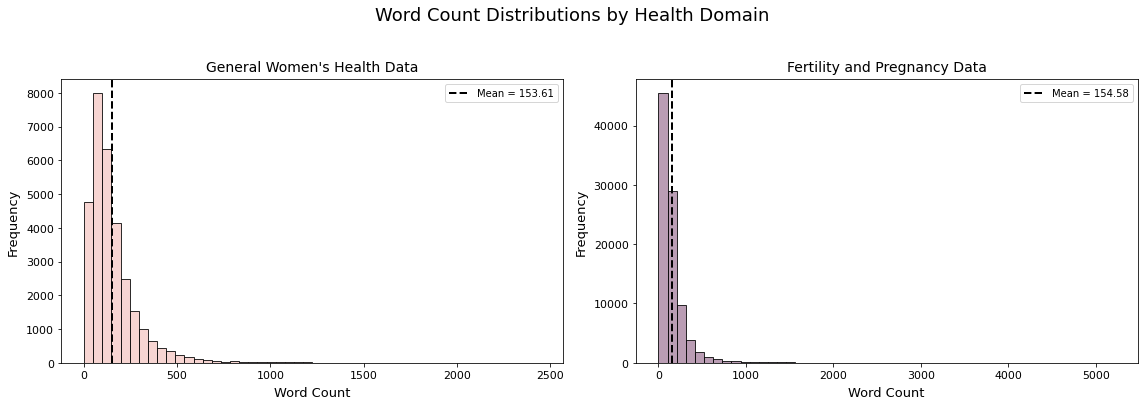

In [54]:
fig, axes = plt.subplots(1, 2, figsize = (16, 5))

ax1 = axes[0]
ax2 = axes[1]

subplot_histogram(health['word_count'], 
                  axis = ax1,
                  mean = 153.61,
                  title = 'General Women\'s Health Data',
                  x_label = 'Word Count',
                  y_label = 'Frequency',
                  color = blush )


subplot_histogram(obsgyn['word_count'], 
                  axis = ax2,
                  mean = 154.58,
                  title = 'Fertility and Pregnancy Data',
                  x_label = 'Word Count',
                  y_label = 'Frequency',
                  color = dark_purple)


plt.suptitle('Word Count Distributions by Health Domain', y = 1.12, size = 18);

As shown in the histograms above, the majority of posts for all three health domains are less than 1000 words in length.

**General Women's Health Domain**: The average word count for the Women's Health domain is 153.6 words, but word counts ranged from 1 to 2447 words. Almost 75% of posts had word counts of 192 words or less. 

**Fertility and Pregnancy Domain**: The average word count for the Fertility and Pregnancy domain was 154.6 words, but word counts varied from 1 to 5215 words. Almost 75% of posts had word counts of 181 words or less.

Overall, it appears that both data sets contain posts with a substantial amount of text.

### Visualizing Most Common Words and Bigrams

In order to get a sense of what words might be important for determining topics and clusters, I will visualize the most common words in each data set. Because stop words occur frequently in a data set without contributing meaning, stop words will be removed from the data prior to visualizing.

#### Functions

In [55]:
def get_word_vector(data, ngrams = (1,1), stopwords = None, min_df = 0.001):
    cvec = CountVectorizer(stop_words = stopwords, ngram_range = ngrams, min_df = min_df)
    words = cvec.fit_transform(data)
    df = pd.DataFrame(words.toarray(), columns = cvec.get_feature_names())
    return df

In [56]:
def get_word_sums(words_df):
    word_sum = {}
    for column in words_df.columns:
        word_sum[column] = words_df[column].sum()
    df = pd.DataFrame(sorted(word_sum.items(), key = lambda x: x[1], reverse = True), columns = ['Word', 'Count'])
    return df.sort_values('Count', ascending = False)

In [57]:
def plot_top_words(word_count_df, num_words = 10, title = None, x_label = None, y_label = None, color = None):
    plt.figure(figsize = (15,8))
    sns.barplot(y = word_count_df['Word'][:num_words], x = word_count_df['Count'][:num_words], orient = 'h', color = color, edgecolor = 'black')
    plt.title(title, fontdict = {'fontsize':18}, pad = 12)
    plt.xlabel('Count', fontdict = {'fontsize':15}, labelpad = 10)
    plt.ylabel('Term', fontdict = {'fontsize':15}, labelpad = 10)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.tight_layout;

### Most Frequent Words in the Original Text Corpus

#### Define Original Text Corpus

In NLP, the collection of text is called a corpus. Each individual item in the corpus is called a document. For this data, the corpus for each domain will be the `total_text` column, and each document will an individual post.

In [58]:
og_health_corpus = health['total_text'].copy()
og_obsgyn_corpus = obsgyn['total_text'].copy()

#### Create a Bag of Words 
To begin the visualization process, each document (post) will be broken down into a bag of words. The bag of words for the corpus will be stored in a document term matrix.  

**Note**: For each bag of words, for a word to be included in the "bag", it must appear in at least 0.01% of the corpus.

In [59]:
swr_health_words = get_word_vector(og_health_corpus, stopwords = full_stop_words)
swr_obsgyn_words = get_word_vector(og_obsgyn_corpus, stopwords = full_stop_words)

In [60]:
swr_health_words.head(1)

,abdomen,abdominal,ability,ablation,able,abnormal,abnormalities,abnormally,abortion,abroad,...,young,younger,youngest,youth,youtube,yr,yrs,zero,zoloft,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Calculate Word Counts

In the data frame above, we can see that each row is a document (post), and each column is a word that appears in the corpus. To get the most frequent words in the corpus, I can find the sum of counts for each word.

In [61]:
swr_health_word_counts = get_word_sums(swr_health_words)
swr_obsgyn_word_counts = get_word_sums(swr_obsgyn_words)

After the words sums have been determined, the top words in the corpus can be plotted.

#### General Women's Health Corpus

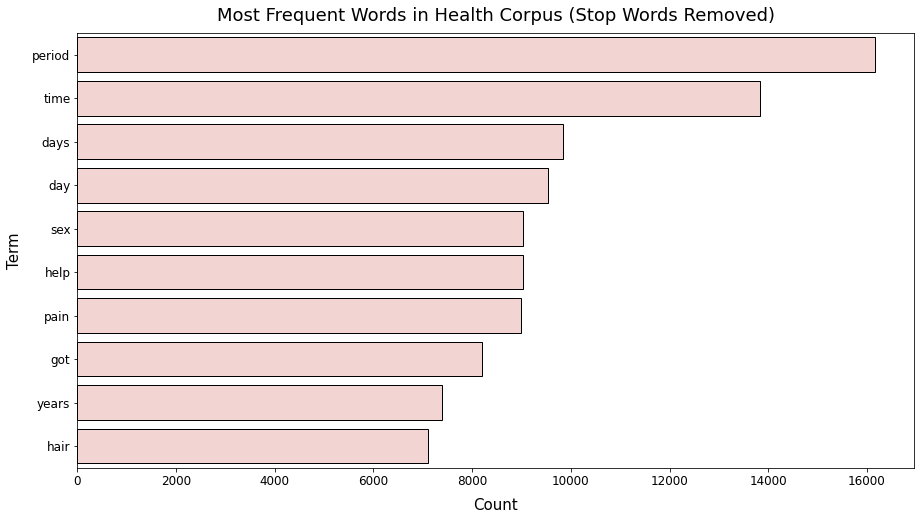

In [62]:
plot_top_words(swr_health_word_counts, 
               title = 'Most Frequent Words in Health Corpus (Stop Words Removed)',
               color = blush)

In the general women's health data, it appears that several documents (posts) contain the words "period", "sex", "pain", "help", and "hair". There are also words that might be used for context, such as "time", "days", "day", "got", and "years". From this visualization, we might expect topics related to a woman's period, sex, pain, and hair.

#### Fertility and Pregancy Data

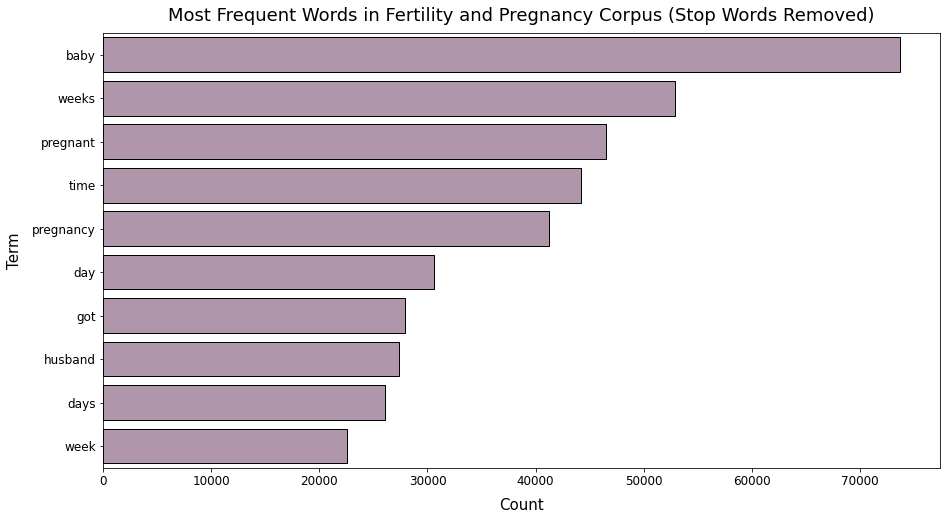

In [63]:
plot_top_words(swr_obsgyn_word_counts, 
               title = 'Most Frequent Words in Fertility and Pregnancy Corpus (Stop Words Removed)',
               color = dark_purple)

In the fertility and pregnancy corpus, as expected, several of the most frequent words are related to pregnancy ("baby", "pregnant", "pregnancy"). These words do not provide insight into any of the specific concerns. There are also context-related words that occur at a large frequency, including "weeks", "time", "day", "days", "week".

### Most Frequent Bigrams by Data Set

In addition to just looking at the top words, I am also interested in looking at the most frequent combinations of two words (bigrams) that appear in the corpus. I can create a bag of words where each term is a combination of two words (bigram).

#### Create Bag of Words

In [64]:
swr_health_bigrams = get_word_vector(og_health_corpus, ngrams = (2,2), stopwords = full_stop_words)
swr_obsgyn_bigrams = get_word_vector(og_obsgyn_corpus, ngrams = (2,2), stopwords = full_stop_words)

#### Calculate Word Counts

In [65]:
swr_health_bigrams_counts = get_word_sums(swr_health_bigrams)
swr_obsgyn_bigrams_counts = get_word_sums(swr_obsgyn_bigrams)

Once the word counts have been summed, the most frequent bigrams can be visualized.

#### General Women's Health Data

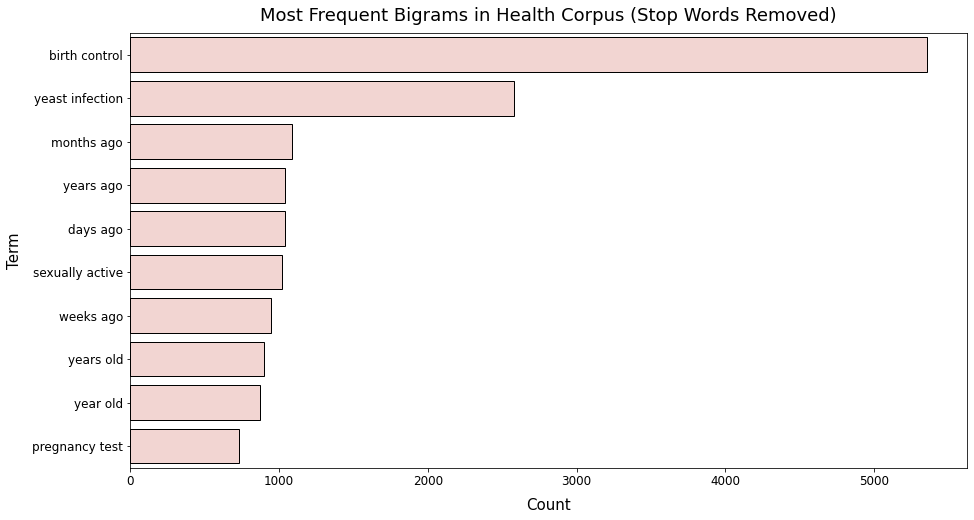

In [66]:
plot_top_words(swr_health_bigrams_counts, 
               title = 'Most Frequent Bigrams in Health Corpus (Stop Words Removed)',
               color = blush)

The visualization of bigrams in the General Women's Health data shows several frequent bigrams that might be related to topics, including "birth control", "yeast infection", "sexually active", and "pregnancy test". Again, there are also bigrams that provide contextual clues to the post, such as "months ago", "years ago", "days ago", "weeks ago", "years old", and "year old". 

#### Fertility and Pregnancy Corpus

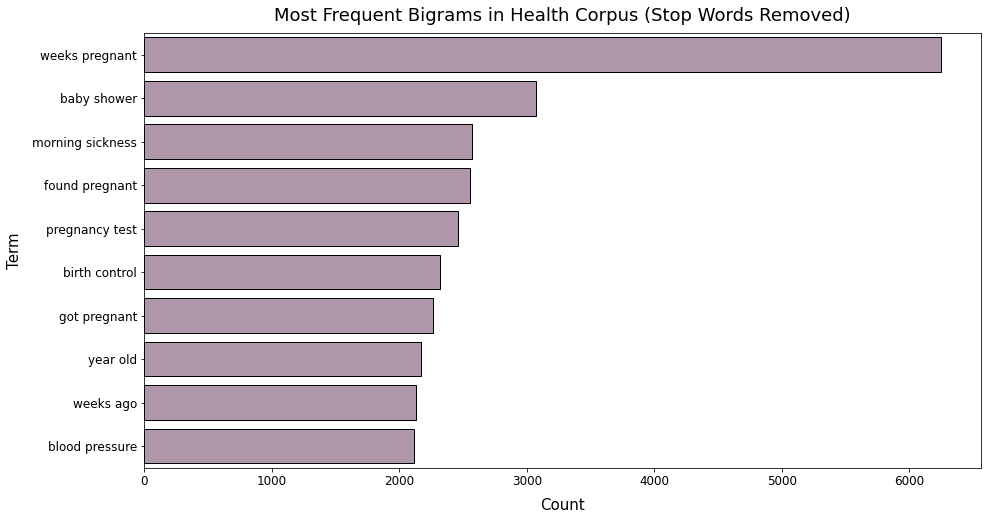

In [67]:
plot_top_words(swr_obsgyn_bigrams_counts, 
               title = 'Most Frequent Bigrams in Health Corpus (Stop Words Removed)',
               color = dark_purple)

The visualization of frequent bigrams shows several terms that could be informative as to possible topics of concern, including "weeks pregnant", "baby shower", "morning sickness", "pregnancy test", "birth control", "got pregnant", and "blood pressure". From these bigrams, we might expect important topics to be related to pregnancy symptoms, determining if one is pregnant, birth control methods, pregnancy complications (such as gestional hypertension or preeclampsia), and pregnancy traditions (like baby showers). Again, there were also several context bigrams ("year old", "weeks ago").

### Most Frequent Trigrams 
In order to gain more insight into possible topics, I am also interested in looking at the most frequent combinations of three words (trigrams). Similar to bigrams, I can create a bag of words where each term is a combination of three words (trigram).

#### Create Bag of Words

In [68]:
swr_health_trigrams = get_word_vector(og_health_corpus, ngrams = (3,3), stopwords = full_stop_words, min_df = 0.005)
swr_obsgyn_trigrams = get_word_vector(og_obsgyn_corpus, ngrams = (3,3), stopwords = full_stop_words, min_df = 0.003)

#### Calculate Trigram Counts

In [69]:
swr_health_trigrams_counts = get_word_sums(swr_health_trigrams)
swr_obsgyn_trigrams_counts = get_word_sums(swr_obsgyn_trigrams)

Once the trigram counts have been calculated, the most frequently-occuring trigrams can be visualized.

#### General Women's Health Corpus

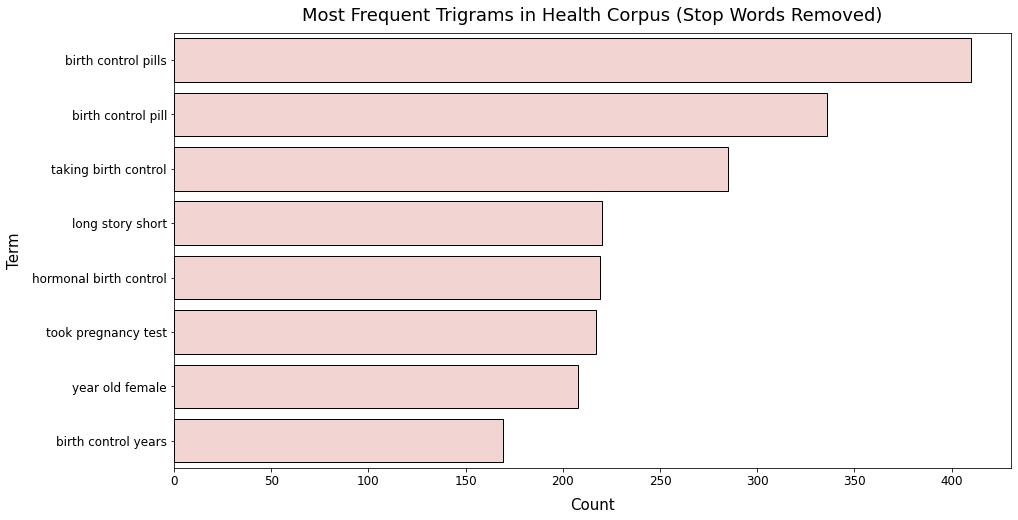

In [70]:
plot_top_words(swr_health_trigrams_counts, 
               title = 'Most Frequent Trigrams in Health Corpus (Stop Words Removed)',
               color = blush)

As shown in the figure above, the most frequent trigrams show that birth control will likely be an important topic in the General Women's Health corpus. Of the top 8 trigrams, 5 are related to birth control. Testing for pregnancy might also be an important theme in the corpus. 

#### Fertility and Pregnancy Corpus

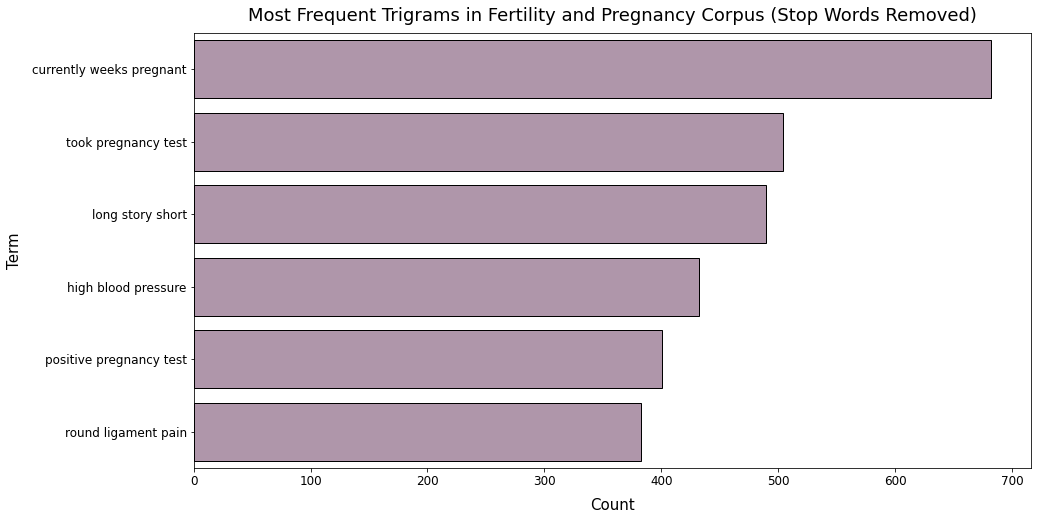

In [71]:
plot_top_words(swr_obsgyn_trigrams_counts, 
               title = 'Most Frequent Trigrams in Fertility and Pregnancy Corpus (Stop Words Removed)',
               color = dark_purple)

The visualization above shows the most frequent trigrams for the Fertility and Pregnancy corpus. Based on these terms, it appears that an important topic will be determination of pregnancy ("took pregnancy test", "positive pregnancy test"), pregnancy complications ("high blood pressure"), and other pregnancy-associated pains ("round ligament pain").

### Visualizing Most Frequent Lemmatized Terms

Visualizing the the most frequent terms from the original text exposed several words, bigrams, and trigrams that begin to illustrate what topics we can expect from each corpus. However, in some cases, the most frequent words were just inflectional variants (e.g. day, days). To explore the most frequent lemmas (base words) in the corpus, I will visualize the most frequent words, bigrams, and trigrams in the lemmatized text.

#### Define Lemmatized Corpus

The lemmatized corpus for each data set is the `lemma_text` feature.

In [72]:
lemmas_health_corpus = health['lemma_text']
lemmas_obsgyn_corpus = obsgyn['lemma_text']

#### Create Bag of Words

In [73]:
lemmas_health_words = get_word_vector(lemmas_health_corpus, stopwords = full_stop_words)
lemmas_obsgyn_words = get_word_vector(lemmas_obsgyn_corpus, stopwords = full_stop_words)

#### Calculate Word Counts

In [74]:
lemmas_health_word_counts = get_word_sums(lemmas_health_words)
lemmas_obsgyn_word_counts = get_word_sums(lemmas_obsgyn_words)

#### General Women's Health Corpus

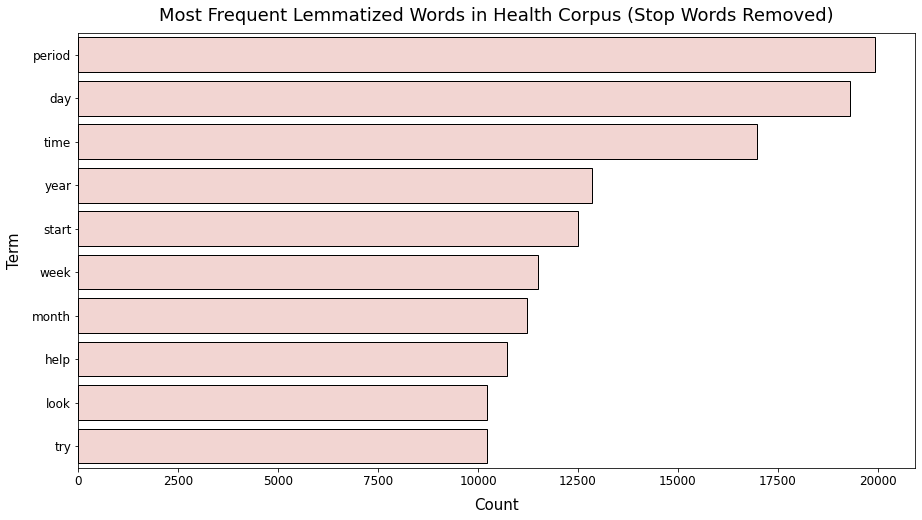

In [75]:
plot_top_words(lemmas_health_word_counts, 
               title = 'Most Frequent Lemmatized Words in Health Corpus (Stop Words Removed)',
               color = blush)

When exploring the most frequently occuring lemmas, it appears that many of them are contextual words ("day", "time", "year", "week", "month", "help", "look"). The only lemma that might provide insight to a potential topic is "period".

#### Fertility and Pregnancy Corpus

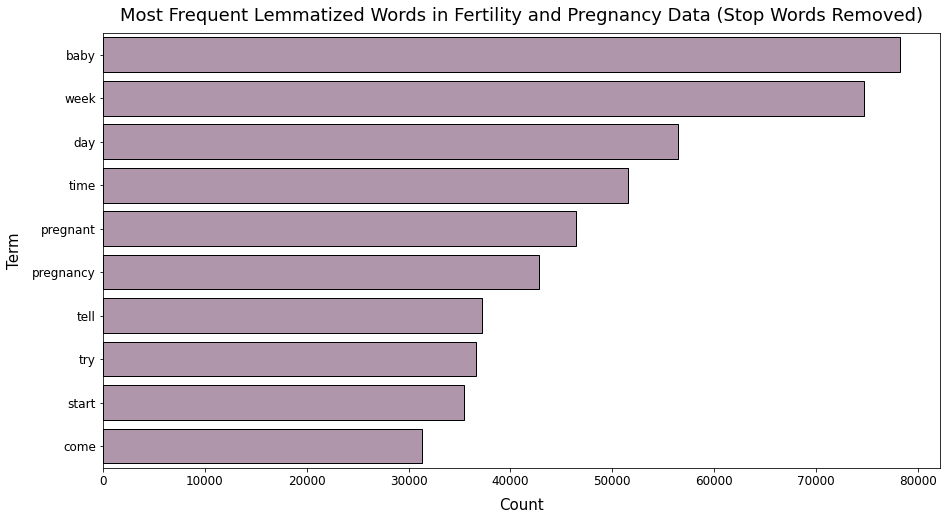

In [76]:
plot_top_words(lemmas_obsgyn_word_counts, 
               title = 'Most Frequent Lemmatized Words in Fertility and Pregnancy Data (Stop Words Removed)',
               color = dark_purple)

Within the Fertility and Pregnancy corpus, the words "baby", "pregnant", and "pregnancy" confirm that an overarching topic will be pregnancy, but they do not provide insight into specific concerns that might be within the corpus. There are several context words, such as "week", "day", and "time", that also do not provide insight into possible topics that could emerge from this corpus.

### Most Frequent Lemma Bigrams

Simliar to the analyses for the original corpus, I am also interested in exploring the most frequent combinations of two lemmas that occur within the corpus (lemma bigram).

#### Create Bag of Words

In [77]:
lemmas_health_bigrams = get_word_vector(lemmas_health_corpus, ngrams = (2,2), stopwords = full_stop_words)
lemmas_obsgyn_bigrams = get_word_vector(lemmas_obsgyn_corpus, ngrams = (2,2), stopwords = full_stop_words)

#### Calculate Bigram Count

In [78]:
lemmas_health_bigrams_counts = get_word_sums(lemmas_health_bigrams)
lemmas_obsgyn_bigrams_counts = get_word_sums(lemmas_obsgyn_bigrams)

#### General Women's Health Corpus

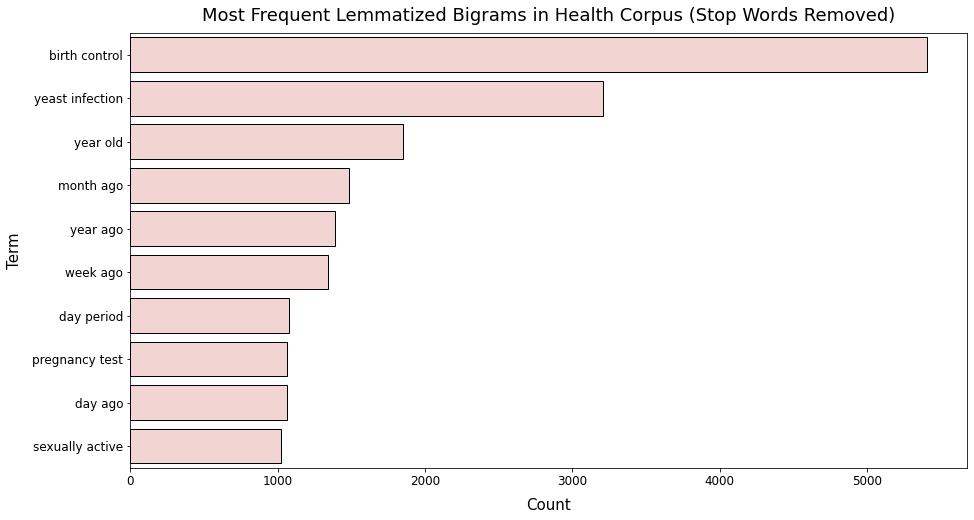

In [79]:
plot_top_words(lemmas_health_bigrams_counts, 
               title = 'Most Frequent Lemmatized Bigrams in Health Corpus (Stop Words Removed)',
               color = blush)

As shown above, the most frequent lemma bigrams in the General Women's Health corpus appear similar to the most frequent bigrams that were previously presented. From these bigrams, we can see that "birth control", "yeast infection", "pregnancy test", and "sexually active" might provide important clues to possible topics. The other bigrams likely provide context clues ("year old", "week ago", "day ago").

#### Fertility and Pregnancy Corpus

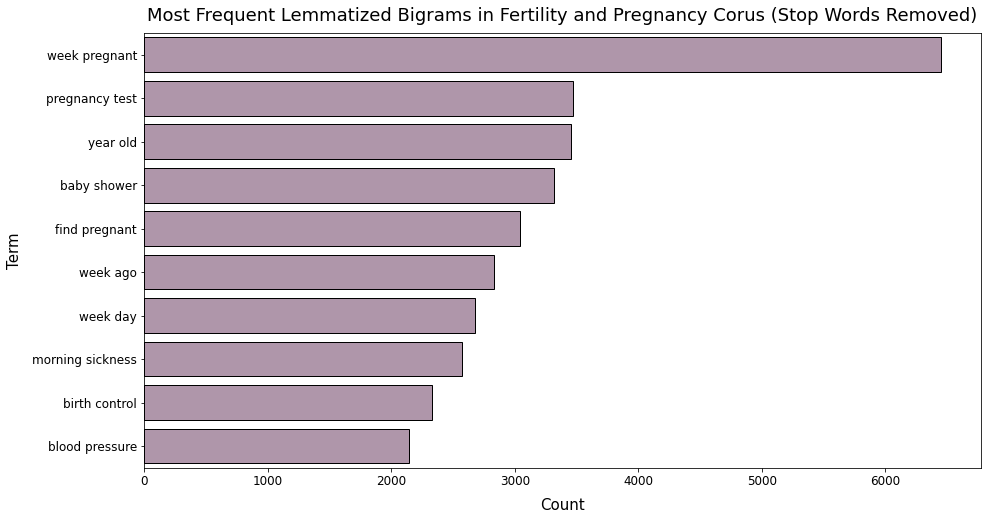

In [80]:
plot_top_words(lemmas_obsgyn_bigrams_counts, 
               title = 'Most Frequent Lemmatized Bigrams in Fertility and Pregnancy Corus (Stop Words Removed)',
               color = dark_purple)

The most frequent lemma bigrams are also similar to the original bigrams. From this list, the bigrams "pregnancy test", "baby shower", "morning sickness", "birth control", and "blood pressure" could provide important insight into possible topics within this corpus.

### Most Frequent Lemma Trigrams

Simliar to the analyses for the original corpus, I am also interested in exploring the most frequent combinations of three lemmas that occur within the corpus (lemma trigram).

#### Create Bag of Words

In [81]:
lemmas_health_trigrams = get_word_vector(lemmas_health_corpus, ngrams = (3,3), stopwords = full_stop_words)
lemmas_obsgyn_trigrams = get_word_vector(lemmas_obsgyn_corpus, ngrams = (3,3), stopwords = full_stop_words, min_df = 0.003)

#### Calculate Trigram Counts

In [82]:
lemmas_health_trigrams_counts = get_word_sums(lemmas_health_trigrams)
lemmas_obsgyn_trigrams_counts = get_word_sums(lemmas_obsgyn_trigrams)

#### General Women's Health Corpus

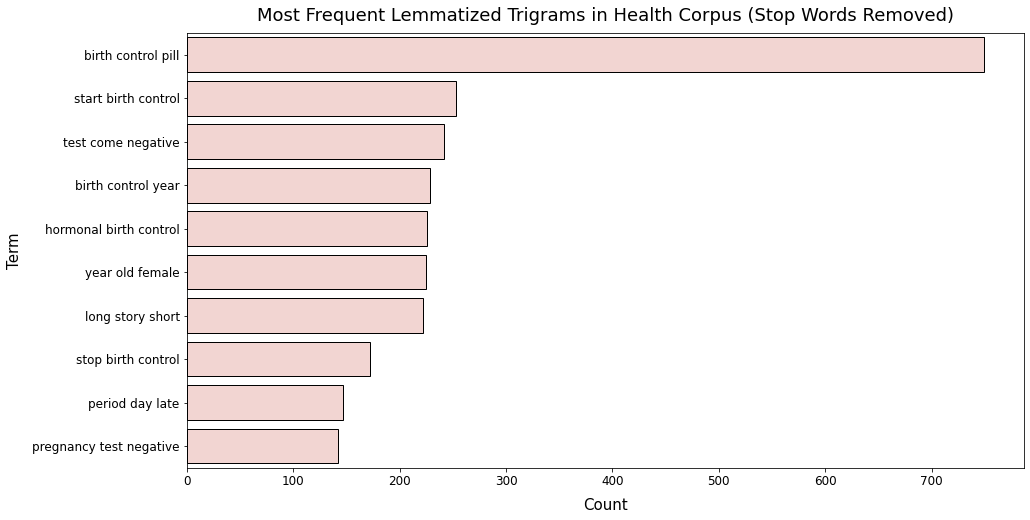

In [83]:
plot_top_words(lemmas_health_trigrams_counts, 
               title = 'Most Frequent Lemmatized Trigrams in Health Corpus (Stop Words Removed)',
               color = blush)

For the General Women's Health corpus, several trigrams could be informative to possible topics within the corpus. The trigrams "birth control pill", "start birth control", "hormonal birth control", and "stop birth control" suggest that Oral Contraceptives might emerge as an important topic. The trigrams "test come negative", "period day late", and "pregnancy test negative" suggest that menstrual irregularities or negative pregnancy tests might be an important topic. 

#### Fertility and Pregnancy Corpus

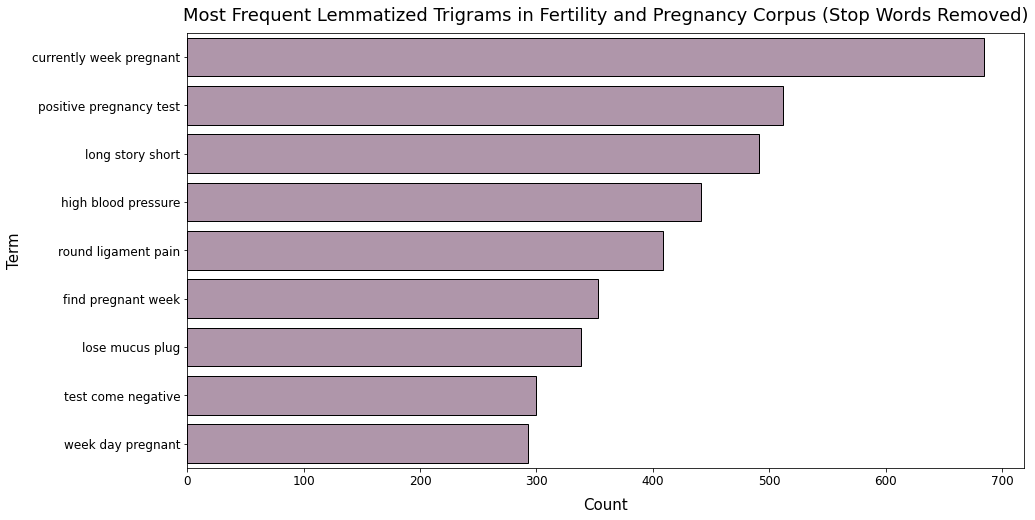

In [84]:
plot_top_words(lemmas_obsgyn_trigrams_counts, 
               title = 'Most Frequent Lemmatized Trigrams in Fertility and Pregnancy Corpus (Stop Words Removed)',
               color = dark_purple)

The most frequent lemma trigrams in the Fertility and Pregnancy corpus provide important clues into possible topics. The terms "positive pregnancy test" and "test come negative" suggest that determination of pregnancy could be an important topic. The term "high blood pressure" suggests that some posts could be about pregnancy complications like gestional hypertension or preeclampsia. The term "round ligament pain" suggests that a possible topic could be related to common pregnancy-related pains, and the term "lose mucus plug" could indicate that an important topic will be related to onset of labor. 

### Sentiment Analysis

Because the text data contained in each corpus likely contains sensitive information about personal or health concerns, understanding the average sentiment score of the documents (posts) in the corpus might allow us to infer possible topics. For example, a negative average score might indicate excessive worry, or a positive average score might indicate discussion of exciting news or comments. I will examine the sentiment distribution for the General Women's Health corpus and Fertility and Pregnancy corpus.

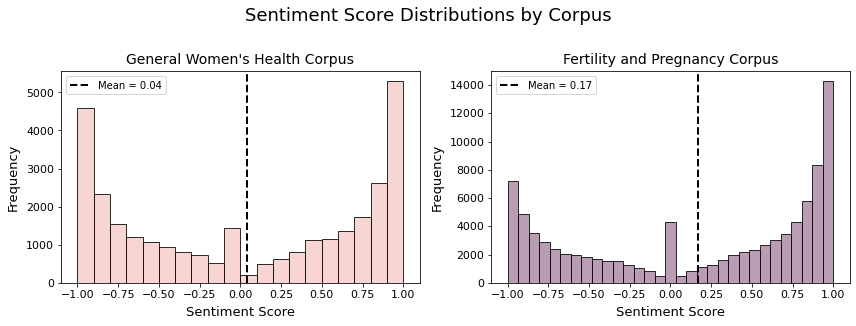

In [85]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

ax1 = axes[0]
ax2 = axes[1]

subplot_histogram(health['sentiment_score'], 
                  axis = ax1,
                  mean = 0.04,
                  title = 'General Women\'s Health Corpus',
                  x_label = 'Sentiment Score',
                  y_label = 'Frequency',
                  color = blush )


subplot_histogram(obsgyn['sentiment_score'], 
                  axis = ax2,
                  mean = 0.17,
                  title = 'Fertility and Pregnancy Corpus',
                  x_label = 'Sentiment Score',
                  y_label = 'Frequency',
                  color = dark_purple)

plt.suptitle('Sentiment Score Distributions by Corpus', y = 1.12, size = 18);

Overall, neither corpus has an average sentiment score that is highly positive or negative. However, the Fertility and Pregnancy corpus has more documents and appears to be more positive than the General Women's Health corpus.

**General Women's Health Corpus**: The mean sentiment score is is 0.04 with a standard deviation of 0.74, indicating a fairly neutral mean. The range of scores is -0.9997 to 0.9998 with a median of 0.07. Seventy-five percent of all documents (posts) have a sentiment score of 0.81 or below.

**Fertility and Pregnancy Corpus**: The mean sentiment score is 0.17 with a standard deviation of 0.73. The range of scores is -0.997 to 1.00 with a median of 0.42. Seventy-five percent of all documents (post) have a sentiment score of 0.87 or below.

## Model Preparation

To prepare for topic modeling with Latent Dirichlet Allocation, the lemmatized text will be vectorized using a TF-IDF vectorizer and converted to a term document matrix than is compatible with the Gensim NLP library. 

Prior to vectorizing the text for modeling, data used to build the models will be read-in. (Data Cleaning and Modeling originally occured in separate notebooks.)

In [86]:
health = pd.read_csv('../data/womens_health_preprocessed.csv', lineterminator='\n')
print(f'Health: {health.shape}')
obsgyn = pd.read_csv('../data/fertility_and_pregnancy_preprocessed.csv')
print(f'ObsGyn: {obsgyn.shape}')

Health: (30616, 7)
ObsGyn: (92943, 7)


Additional stop words that are believed to not contribute meaning to the topics will also be added to the list of stop words

In [87]:
# Update Stop Words
words_to_add = ['like', 'know', 'want', 'feel', 'going', 'think', 'reddit', 'imgur', 'pron', 'officially', 'story', 'month', 'week', 'time', 'day', 'year', 'delete', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'subreddit']

add_stop_words(words_to_add, full_stop_words)
remove_stop_words(['not'], full_stop_words)

### Create Document Term Matrix From Corpus

In order to convert each document (post) in the corpus to a vector, I will use ***Sklearn***'s `TfidfVectorizer`. TF-IDF stands for Term Frequency-Inverse Document Frequency. Essentially, using this vectorizer, words that appear frequently in a document but also appear frequently in several documents throughout the corpus are not weighted as heavily as words that appear frequently in a document but infrequently in the corpus. For an overview of TF-IDF, check out this [video](https://www.youtube.com/watch?v=4vT4fzjkGCQ). 

#### Function

In [88]:
def build_tvec(df, column, stop_words = full_stop_words):
    tvec = TfidfVectorizer(max_df = 0.98, min_df = 0.005, ngram_range = (1,2), stop_words = stop_words)
    dtm = tvec.fit_transform(df[column])
    return tvec, dtm

#### Create Document-Term Matrix
A document-term matrix is a matrix that contains the frequency of words that occur in a document. The columns are words and the rows each correspond to a document.

In [89]:
# Vectorizer, dtm are outputed from build_tvec

health_vectorizer, health_dtm = build_tvec(health, 'lemma_text')
obsgyn_vectorizer, obsgyn_dtm = build_tvec(obsgyn, 'lemma_text')

#### Transform Document Term Matrix into a Term Document Matrix that can be recognized by Gensim

Gensim requires the format of the input to be a Gensim corpus data type. In order to convert the document-term matrix to a corpus, we must first convert it to a term-document matrix, which is the tranpose of the document-term matrix. Once the term-document matrix is created, it is converted to a compressed sparse row matrix, and finally a Gensim corpus.

**Note**: Code for these steps was modified from [A Dash of Data](https://github.com/adashofdata/nlp-in-python-tutorial) by Alice Zhao

##### Functions

In [90]:
def create_tdm(dtm):
    tdm = dtm.transpose() # transpose document-term matrix
    return tdm

In [91]:
def tdm_to_gensim_corpus(tdm):
    sparse = scipy.sparse.csr_matrix(tdm) # Create a compressed sparse row matrix
    corpus = matutils.Sparse2Corpus(tdm) # Create a corpus from sparse matrix
    return corpus

In [92]:
def prepare_dtm_for_gensim(dtm):
    tdm = create_tdm(dtm)
    corpus = tdm_to_gensim_corpus(tdm)
    return corpus

##### Convert to Gensim Corpus

In [93]:
health_corpus = prepare_dtm_for_gensim(health_dtm)
obsgyn_corpus = prepare_dtm_for_gensim(obsgyn_dtm)

## Define Vocabulary Dictionary from Vectorizer

Gensim also requires that a dictionary, containing the vocabulary and index of the term, is input into the model. This can be done using a dictionary comprehension or using the `.from_corpus` method. 

#### Dictionary to be used with modeling
For modeling, a dictionary was created using a dictionary comprehension with the vectorizer vocabulary.

In [94]:
# Code modified from A Dash of Data by Alice Zhao

def create_vocab_dictionary(vectorizer):
    vocab_dictionary = dict((v,k) for k,v in vectorizer.vocabulary_.items())
    return vocab_dictionary

In [95]:
health_vocabulary = create_vocab_dictionary(health_vectorizer)
obsgyn_vocabulary = create_vocab_dictionary(obsgyn_vectorizer)

#### Dictionary to be used with pyLDAvis
The ***pyLDAvis*** library requires the Dictionary to be a Gensim object. Therefore, the Gensim corpus was converted to a gensim dictionary.

In [96]:
# https://stackoverflow.com/questions/21552518/using-scikit-learn-vectorizers-and-vocabularies-with-gensim

health_gensim_dict = Dictionary.from_corpus(corpus = health_corpus, id2word = health_vocabulary)
obsgyn_gensim_dict = Dictionary.from_corpus(corpus = obsgyn_corpus, id2word = obsgyn_vocabulary)

Following these steps, the data is prepared to be used in a Gensim Latent Dirichlet Allocation model.

## Topic Modeling with Latent Dirichlet Allocation

In order to identify possible topics related to women's health concerns, **Latent Dirichlet Allocation (LDA)** was conducted for the General Women's Health corpus and the Fertility and Pregnancy corpus. 

Latent Dirichlet Allocation was first described in 2003 by David M. Blei, Andrew Ng, and Michael I. Jordan [(5)](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf). In simple terms, LDA assumes that there are hidden (latent) topics in a corpus. Within the corpus, each document is a probability distribution of the latent topics, and each topic is a probability distribution of the words in the corpus. For interpretation, the document can be assigned to the topic with the highest probability, and the words with the highest probability of appearing in the topic can be used to infer topic meaning. 

The general process of LDA is:
1. Choose a number of topics (K)
2. For each document in the corpus, randomly assign the words in a document to a topic. (This step generates a list of topics in the documents and a list of words for each topic.)
3. Iterate over the document, reassigning the words and topics based on p(word|topic) and p(topic|document) until a steady state is reached.

After this process, you can view the topic probability distribution for each document and the word probability distribution for each topic. 

**NOTE**: The course "Natural Language Processing with Python" by Jose Portilla provided this background knowledge.

The Gensim topic modeling library provides an LDA model that will be used to identify topics in each corpus. Because LDA is an iterative process, the LDA model will run for 50 iterations.

### Functions

In [97]:
def build_gensim_lda(corpus, n_topics, vocabulary, n_passes):
    lda = LdaModel(corpus = corpus, num_topics = n_topics, id2word = vocabulary, passes = n_passes, decay = 0.7, offset = 10, random_state = 2020)
    return lda

In [98]:
def build_gensim_coherence_model(model, corpus, dictionary):
    coherence = CoherenceModel(model = model, corpus = corpus, dictionary = dictionary, coherence = 'u_mass')
    return round(coherence.get_coherence(), 3)

In [99]:
def get_topic_terms(model, n_topics, n_words):
    return model.print_topics(num_topics = n_topics, num_words = n_words)

In [100]:
# Function Written By Selva Prabhakaran
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def assign_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]): # iterate over transformed corpus to get topic probabilities for document
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Probability and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Probability', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    sent_topics_df.columns = ['Dominant_Topic', 'Probability', 'Keywords', 'Original_Text']
    
    return sent_topics_df

In [101]:
def display_pyLDAvis(model, corpus, gensim_dict):
    prepared = pyLDAvis.gensim.prepare(model, corpus, gensim_dict)
    display = pyLDAvis.display(prepared)
    return display

### Determining the Optimal Number of Topics to Use

When conducting LDA, one of the biggest challenges is determining the optimal number of topics to use in the model. 

To help with this process, as shown below, I built a grid search function that fitted models with a range of topics and returned a list of coherence scores (Put simply, coherence is a measure of similarity of words in a topic.) and a dictionary containing the models. Due to computation time, the grid search was allowed to run for only 10 iterations.  The function is shown in the [Grid Search Models](https://github.com/jlu90/Identifying-Womens-Health-Concerns/blob/master/code/03_grid_search_models.ipynb) notebook. The results of these searches yielded the following plots:

<img src='../assets/health_coherence.png'> 

<img src='../assets/obsgyn_coherence.png'> 

To interpret the results of the grid search, I began by choosing to explore the model with the best UMass coherence score (score closest to 0). Using that model, I looked at the words with the highest probability of occurring in each topic and decided if the topics made sense or if they seemed random, keeping in mind that the words and topics might change with more iterations. I did this for several different models until I found the number of topics that resulted in highly interpretable topics. 

From there, I built a model using the identified number of topics that ran for 50 iterations and evaluated the interpretability of the topics. If the topics looked good, the model was final, but if the topics seemed vague or random, the model with the next best coherence was chosen for evaluation. This process continued until models with interpretable results were achieved.

***For the General Women's Health corpus, the optimal number of topics was decided to be 12, and for the Fertility and Pregnancy corpus, the optimal number of topics was determined to be 10. These models will be built below.***

### General Women's Health Data

#### Build a LDA model with 12 topics

In [102]:
health_lda_model = build_gensim_lda(health_corpus, 
                               n_topics = 12, 
                               vocabulary = health_vocabulary, 
                               n_passes = 50)

#### Evaluate Model on UMass Coherence

In [103]:
build_gensim_coherence_model(health_lda_model, corpus = health_corpus, dictionary = health_vocabulary)

-2.334

The LDA model with 12 topics has a coherence score of -2.3. Given that UMass coherence scores can range from 0 (best) to -14 (worst), this is a fairly good score and indicates that words within a topic are similar.

#### Evaluate Topic Separation and Check Relevant Terms using pyLDAvis

In [104]:
display_pyLDAvis(health_lda_model, health_corpus, health_gensim_dict)

The ***pyLDAvis*** library was built to enable easier interpretation of topic models. On the left, the topics are plotted across two principle components. Similarity of topics is shown by proximity of topic circles, and the size demonstrates how prevalent the topic is in the corpus. On the right, the 30 most salient terms in the corpus are shown. If the cursor is placed over a topic circle, the right panel changes to show the relevant terms to the topic.

Based on this figure, we are able to see that each topic seems to encapsulate a fairly good amount of the corpus (medium to large sized topics), but there is some overlap. Given the information gain from the overlapping topics, this was determined to be okay. An in-depth topic interpretation based on salient terms will follow in the [Topic Interpretation](#Topic-Interpretation-and-Evaluation) section. 

### Fertility and Pregnancy Data

#### Build LDA model with 10 topics

In [105]:
%%time
obsgyn_lda_model = build_gensim_lda(obsgyn_corpus, 
                               n_topics = 10, 
                               vocabulary = obsgyn_vocabulary, 
                               n_passes = 50)

CPU times: user 19min 46s, sys: 2.72 s, total: 19min 49s
Wall time: 19min 51s


#### Evaluate Model on UMass Coherence Score

In [106]:
build_gensim_coherence_model(obsgyn_lda_model, corpus = obsgyn_corpus, dictionary = obsgyn_vocabulary)

-1.961

The LDA model with 10 topics has a coherence score of -1.96. Given that UMass coherence scores can range from 0 (best) to -14 (worst), this is a good score and indicates that words within a topic are similar.

#### Evaluate Topic Separation and Check Relevant Terms using pyLDAvis

In [107]:
display_pyLDAvis(obsgyn_lda_model, obsgyn_corpus, obsgyn_gensim_dict)

Based on this figure, the topics identified by this model seem to show fairly good separability and also seem to include fairly large amounts of the corpus. Again, the overlapping topics contribute interpretable topic information, so this overlap was evaluated to be okay.

## Topic Interpretation and Evaluation

With the Gensim library, I am able to view the word distributions that were calculated for each topic, and the topic distributions that were determined for each document. The interpretation process will be described below.

### Functions

In [108]:
def get_topic_terms(model, n_topics, n_words):
    return model.print_topics(num_topics = n_topics, num_words = n_words)

In [109]:
# Function Written By Selva Prabhakaran
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def assign_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]): # iterate over transformed corpus to get topic probabilities for document
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Probability', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    sent_topics_df.columns = ['Dominant_Topic', 'Probability', 'Keywords', 'Original_Text']
    
    return sent_topics_df

In [110]:
def plot_topics_in_corpus(df, column, color, title = None, x_label = None):
    plt.figure(figsize = (15, 8))
    round(df[column].value_counts(normalize = True) * 100, 2).sort_values(ascending = True).plot.barh(color = color, ec = 'k', width = 0.75);
    plt.title(title, fontdict = {'fontsize': 20}, pad = 18)
    plt.xlabel(x_label, fontdict = {'fontsize': 15}, labelpad = 10)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.tight_layout();

In [111]:
def filter_df_by_topic(df, column, topic):
    filtered_df = df[df[column] == topic]
    filtered_df = filtered_df.sort_values(by = "Probability", ascending = False)
    return filtered_df

In [112]:
def get_top_posts(df):
    topic_df_dict = {}
    top_posts_dict = {}
    percent_dominant = {}
    for topic in df['Dominant_Topic'].unique():
        topic_df_dict[topic] = filter_df_by_topic(df, 'Dominant_Topic', topic)
        topic_df = topic_df_dict[topic]
        top_post = topic_df[topic_df['Probability'] == topic_df['Probability'].max()]['Original_Text'].values
        top_posts_dict[topic] = profanity.censor(top_post[0])
        percent_dominant[topic] = topic_df['Probability'].max()
    
    return top_posts_dict, percent_dominant

### General Women's Health Corpus

#### Explore Top Terms for Each Topic
**Note:** Top terms are determined based on their probability for occuring in the topic.  

For each topic, we are able to view the terms with the highest probability of appearing in the topic. An example is shown in the cell below:

In [113]:
get_topic_terms(health_lda_model, 1, 5) # Will show the words with the highest probability for topic chosen at random

[(1,
  '0.119*"tampon" + 0.095*"cup" + 0.067*"pad" + 0.057*"menstrual" + 0.045*"menstrual cup"')]

Above, we see a list containing a tuple. The first item in the tuple is the topic number, and the second item is a string that contains the probability of a word appearing in the topic and the word itself. I have chosen to display only the top five words.

We can save a list of of the topics and top terms to a list (below), and use indexing to explore the topics and terms in this list. 
This exploration allows us to derive meaning from the topics. 

In [114]:
health_lda_topic_terms = get_topic_terms(health_lda_model, 12, 20)

In the table below, the twelve topics that were indentified in the General Women's Health corpus are presented. As seen below, there were three topic clusters that were not related to women's health.

<h4 align = center> Topics Related to Women's Health Concerns </h4>

| Topic Number| Name| Top 5 Terms |
|:-:|:-:|:-:|
|0|Infections (Yeast Infection and Bacterial Vaginosis)|infection, yeast, yeast infection, discharge, smell|
|1|Feminine Hygiene Products| tampon, cup, pad, menstrual, menstrual cup|
|4| Pains| pain, period, cyst, cramp, doctor|
|5| Body Image and Self-Esteem| eat, food, self esteem, esteem, diet|
|6| Birth Control (Intrauterine Devices and Implants)| IUD (intrauterine device), control, birth, birth control, pill|
|7| General Gynecological Health| vagina, breast, sex, pap, hurt|
|8| Infections (Urinary Tract Infections)| UTI (urinary tract infection), pee, drink, antibiotic, orgasm|
|9| Birth Control (Oral Contraceptives and Condoms)| pill, birth control, birth, control, pack|
|10| Menstrual Cycle and Abnormalities| period, bleed, start, test, pregnancy|

<h4 align = center> Topics Not Related to Health Concerns </h4>

|Topic Number| Name| Top 5 Terms |
|:-:|:-:|:-:|
|2| Social Relationships| friend, guy, people, work, thing|
|3| Hair and Depilation| hair, shave, skin, look, wax|
|11| Fashion| wear, dress, bra, look, buy|

From this data set, the following women's health concerns emerged:

* **Infections (Yeast Infections and Bacterial Vaginosis)**: The top five terms for this topic were "infection", "yeast", "yeast infection", "discharge", and "smell". However, other words that were seen in this topic cluster include mentions of "BV" (bacterial vaginosis), words related to anatomical location ("vagina", "vaginal"), and other vaginal symptoms ("itch", "itching", "symptom").

* **Infections (Urinary Tract Infections)**: The top five terms for this topic were "UTI" (urinary tract infection), "pee", "drink", "antibiotic", and "orgasm". Other words related to urinary tract infections included descriptions of symptoms: "burn", "urine", "bladder", "sensation". The words "sex" and "orgasm" were also included in this cluster. Given that sexual intercourse can be a source of bacteria that might lead to a urinary tract infection, it is possible that these terms were included in posts as a possible cause of the infection.

* **Menstrual Cycle and Abnormalities**: The top five terms for this topic were "period", "bleed", "start", "test" and "pregnancy". Words such as "period", "bleed", "start", "normal", "cycle", and "blood" suggest that the topic is about the menstrual cycle. Words such as "test", "pregnancy", "pregnant", "late", "spot", "pill", and "light" suggest that this topic might describe menstrual cycle abnormalities, such as a late or missed period, possibility of pregnancy, spotting, or a lighter than usual period.

* **Feminine Hygiene Products**: The top five words for this topic were "tampon", "cup", "pad", "menstrual", and "menstrual cup". All of these words are commonly used feminine hygiene products used during a woman's period. Additionally, words that suggest advice on how or when to use these products emerged, including "use", "try", "insert", and "wear". Events which might require a feminine hygiene product also emerged, including "abortion" and "period".

* **General Gynecological Health**: The top five words for this topic were "vagina", "breast", "sex", "pap" (pap smear), and "hurt". This cluster contained words related to the routine gynecological exam, including "pap", "smear", "pap smear", and "doctor". This topic also seemed to capture concerns about possible tumors ("lump", "bump") and general pains ("hurt", "pain", "painful"). All of the concerns in this topic are things that would be discussed at an annual gynecological exam.

* **Pains**: The top five words for this topic were "pain", "period", "cyst", "cramp", "doctor". This topic seemed to capture common pains that women experience, including period pain ("period", "cramp", "pelvic"), as well as pains related to ovarian cysts ("ovary", "ovarian", "cyst", "pelvic", "right"). The term "ultrasound" suggests that this topic might also include procedures used to detect ovarian cysts.

* **Birth Control (Intrauterine Devices and Implants)**: The top five words for this topic were "IUD" (intrauterine device), "control", "birth", "birth control", an "pill". Although the posts in this topic were likely related to birth control, several words suggest that the questions were about alternatives to oral contraceptives. The words "implant" and "Nexplanon" (a type of implant) suggest birth control implants, while the words "IUD", "Mirena" (a brand of IUD), "copper", and "hormonal" could be discussing hormonal and non-hormonal versions of IUDs. It appears that this topic might also include posts about experiences with these birth control methods, including possible effects on "acne" and "mood".

* **Birth Control (Oral Contraceptives and Condoms)**: The top five words for this topic were "pill", "birth control", "birth", "control", and "pack". Several of these words, including the top five, suggest that this topic includes posts about oral contraceptives. Other words that suggest oral contraceptives are "control pill", "plan" (maybe Plan B), "placebo", "bc" (birth control), and "miss" (possibly a missed pill). "Condom" is also the 6th most common word, which suggests that condoms as a form of birth control might also be included in this topic.

* **Body Image and Self-Esteem**: The top five words for this category were "eat", "food", "self esteem", "esteem", and "diet". Several words suggest that this topic might include posts about body image and self-esteem, including "eat", "food", "self esteem", "esteem", "diet", "vitamin", "belly", "insecure", "supplement", and "cope". 

There were three topics not related to women's health:
* **Social Relationships**: The top five terms for this topic are "friend", "guy", "people", "work", "thing", and "talk". The terms in this category seemed to describe both platonic and romantic relationships. Example terms include: "friend", "date", "relationship", "guy", "girl", and "love". The words "work", "job", and "school" suggest that professional relationships might also be discussed in this topic.
* **Hair and Depilation**: The top five terms for this topic are "hair", "shave", "skin", "look", and "wax". This category seems to encompass hair styles ("hair", "face", "grow", "dry", "long", "cut", "dye", "shampoo", "color"), hair removal ("shave", "wax"), and other topics related to beauty ("skin", "look", "makeup", "lip").
* **Fashion**: The top terms for this topic are "wear", "dress", "bra", "look", and "buy". Several words in this topic seem to be related to apparel and fashion, including: "dress", "buy", "clothe", "size", "weight", "jean", "fit", "style", "shoe", "short", "shirt", "pant", and "underwear".

Now that I am able to understand the meaning of each topic, I can determine which topic each document (post) in the corpus belongs to.

#### Explore How Topics Relate to Original Data

For each document (post) in our corpus, I am able to assign it to a topic. Each document was assigned to the topic with the highest probability.

##### Assign Topics and Rename Topic Numbers 

In [115]:
health_topic_df = assign_topics_sentences(health_lda_model, health_corpus, health['total_text'])

To increase readability, the names of each topic can be changed to describe their composition.

In [116]:
health_topic_df['Dominant_Topic'] = health_topic_df['Dominant_Topic'].map({0.0: 'Infections (Yeast Infection and Bacterial Vaginosis)',
                                                    1.0: 'Feminine Hygiene Products',
                                                    2.0: 'Social Relationships',
                                                    3.0: 'Hair and Depilation',
                                                    4.0: 'Pains',
                                                    5.0: 'Body Image and Self-Esteem',
                                                    6.0: 'Birth Control (Intrauterine Devices and Implants)',
                                                    7.0: 'General Gynecological Health',
                                                    8.0: 'Infections (Urinary Tract Infections)',
                                                    9.0: 'Birth Control (Oral Contraceptives and Condoms)',
                                                    10.0: 'Menstrual Cycle and Abnormalities',
                                                    11.0: 'Fashion'})

I can now plot the normalized value counts for each topic in the corpus.

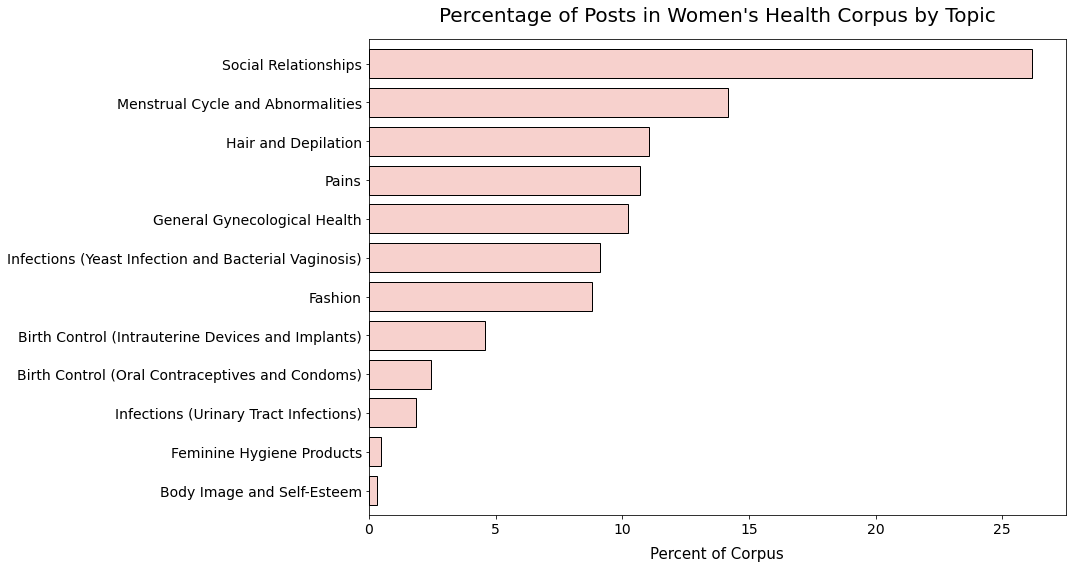

In [117]:
plot_topics_in_corpus(health_topic_df, 
                      'Dominant_Topic', 
                       blush,
                       title = 'Percentage of Posts in Women\'s Health Corpus by Topic',
                       x_label = 'Percent of Corpus')

In the above figure, we see that "Social Relationships" was the most prevalent topic in the General Women's Health Corpus. Many of these posts likely came from r/TheGirlSurvivalGuide, which allows for posts outside of health concerns. Many people also turned to Reddit to discuss menstrual abnormalities, pains, general gynecological concerns, and infections.

#### Evaluate the Topics by Assessing the Content of the Post Determined to Have the Highest Probability of Belonging to the Topic

In order to determine if the topics that I identified captured the meaning of the documents (posts), I filtered out the posts with the highest probability of belonging to a specified topic. I read each post and determined if the topic label seems to match the human-interpreted content. The results are presented in the data frame below.

**Note**: To prevent any vulgar language from appearing, posts were filtered using Better Profanity, a library that replaces profanity with "*"

In [118]:
health_posts_dict, health_dominance_dict = get_top_posts(health_topic_df)
top_health_posts_df = pd.DataFrame.from_dict({'Most Representative Post': health_posts_dict, 
                                              'Probability': health_dominance_dict, 
                                              'Topic Match': {'Infections (Yeast Infection and Bacterial Vaginosis)': 'Yes',
                                                              'Menstrual Cycle and Abnormalities': 'Yes',
                                                              'Birth Control (Intrauterine Devices and Implants)': 'No',
                                                              'Pains': 'Yes',
                                                              'Feminine Hygiene Products': 'Yes',
                                                              'Infections (Urinary Tract Infections)': 'Yes',
                                                              'Birth Control (Oral Contraceptives and Condoms)': 'Yes',
                                                              'Fashion': 'Yes',
                                                              'General Gynecological Health': 'Yes',
                                                              'Hair and Depilation': 'Yes',
                                                              'Social Relationships': 'Yes',
                                                              'Body Image and Self-Esteem': 'Yes'}})

top_health_posts_df

,Most Representative Post,Probability,Topic Match
Infections (Yeast Infection and Bacterial Vaginosis),"Yeast Infection, BV, and ANOTHER Yeast infecti...",0.9155,Yes
Menstrual Cycle and Abnormalities,Am I overreacting to bleeding between periods?...,0.9183,Yes
Birth Control (Intrauterine Devices and Implants),I suspect birth control pills may be causing d...,0.8826,No
Pains,"My GYNO/Doctor Is Ignoring My Pain, and It's B...",0.9273,Yes
General Gynecological Health,Terrified of penetration but I need a pelvic e...,0.9044,Yes
Fashion,Seeking Plus-Size Friendly Online Stores with ...,0.8990,Yes
Social Relationships,Opening up about my traumatic past with bullyi...,0.9339,Yes
Birth Control (Oral Contraceptives and Condoms),what were your experiences and side effects fr...,0.8552,Yes
Infections (Urinary Tract Infections),"UTI help Hi girls, so I’m pretty sure I have m...",0.8470,Yes
Hair and Depilation,A rave review for at-home IPL hair removal! I ...,0.9073,Yes


The most representative posts can be viewed by using the following code for each index:

```python
top_health_posts_df.loc[index, 'Most Representative Post']
```

As shown in the table above, overall, the topics that were identified from the relevant words seem to match the topic of the most representative post. Only the post for "Birth Control (Intrauterine Devices and Implants)" was not a match. This post talked about depression and birth control pills. This post seemed to be a better fit for "Birth Control (Oral Contraceptives and Condoms)", but the general sentiment of unhappiness with birth control pills might have resulted in it being group with the IUD topic.

### Fertility and Pregnancy Data

#### Explore Top Terms for Each Topic
**Note:** Top terms are determined based on their probability for occuring in the topic.

In [119]:
obsgyn_lda_topic_terms = get_topic_terms(obsgyn_lda_model, 10, 30)

The most probabable terms for each topic in the corpus are shown in the table below.

<h4 align = center> Topics Related to Fertility and Pregnancy Concerns </h4>

| Topic Number| Name| Top 5 Terms |
|:-:|:-:|:-:|
|0| Pregnancy Life Changes| birth, work, baby, hospital, leave
|1| Pregnancy Announcement| baby, pregnant, tell, husband, family
|2| Labor and Delivery| contraction, labor, cm (centimeters), induction, induce
|3| Nausea and Vomiting During Pregancy| eat, sleep, food, nausea, morning
|4| Determination of Pregnancy| test, period, pregnancy, pregnant, positive
|6| Fertility| cycle, ovulation, TTC (trying to conceive), try, ovulate
|8| Obstetrics Appointments| ultrasound, doctor, blood, baby, appointment
|9| Pregnancy Pains and Body Changes| pain, belly, baby, weight, kick

<h4 align = center> Topics Not Related to Health Concerns </h4>

| Topic Number| Name| Top 5 Terms |
|:-:|:-:|:-:|
|5| Recommendations for Products|maternity, pregnancy, pregnant, recommendation, bra
|7| Items for the New Baby| baby, buy, shower, nursey, diaper

From this data set, the following women's health concerns emerged:

* **Pregnancy Life Changes**: The top five terms for this topic are "birth", "work", "baby", "hospital", and "leave". Overall, this topic seems to be clustered around preparing for the experience of pregnancy and labor and the associated life changes that come with this major life change. Terms related to pregnancy and delivery are: "birth", "baby", "hospital", "csection" (C-Section), "pregnant", "pregnancy", "delivery", "doctor", and "labor". Terms indicative of life changes include: "work", "leave", "job", "plan", and "insurance".

* **Pregnancy Announcement**: The top five terms in this topic are: "baby", "pregnant", "tell", "husband", and "family". These terms, along with "people", "friend", "mom", "work", and "excited", suggest that posts in this topic might be about announcing the pregnancy to family members, friends, and the place of employment. 

* **Labor and Delivery**: The top five terms for this topic are "contraction", "labor", "cm" (centimeters), "induction", and "induce", suggesting that this topic is related to labor and delivery of the baby. Other terms in this topic that are related to the process of labor and delivery include: "epidural", "water", "pain", "dilate", "push", "cervix", "hospital", "labour", "braxton" (Braxton Hicks contractions), "water break", "hicks", and "braxton hicks". 

* **Nausea and Vomiting During Pregnancy and Sleep Difficulties**: The top five terms in this topic are: "eat", "sleep", "food", "nausea", and "morning". Many of the top terms in this topic are related to nausea and vomiting during pregnancy (NVP), as well as possible sleeping difficulties during pregnancy. Terms related to NVP include: "eat", "food", "nausea", "morning", "sickness", "morning sickness", "sick", "drink", "throw", "smell", "nauseous", and "hungry". Terms related to possible sleep difficulties include: "sleep", "night", "wake", "tired", and "bed".

* **Determination of Pregnancy**: The top five terms in this topic are "test", "period", "pregnancy", "pregnant", and "positive". Many of the top terms in this topic are related to pregnancy tests and determining if a woman is pregnant. Terms about pregnancy tests include: "test", "positive", "pregnancy test", "negative", and "line" (possible line on pregnancy test). Terms about determining pregnancy status are related to abnormal period symptoms ("period", "bleed", "spot", "late", "blood", "light", "cramping", "brown", "discharge", and "bleeding"), as a late period, cramping, spotting, and discharge can all occur in early pregnancy. The words "miscarriage", "cramping", and "bleeding" could also indicate that this topic also captures posts about miscarriage. 

* **Fertility**: The top five terms in this topic are "cycle", "ovulation", "TTC" (trying to conceive), "try", and "ovulate". Overall, the top terms in this topic appear to be related to fertility and ovulation. Top terms can be grouped based on *hormones* ["progesterone", "clomid" (an estrogen modulator), and "LH" (lutenizing hormone)], *ovulation tracking* ["cycle", "ovulation", "ovulate", "OPK" (ovulation predictor kit), and "temp" (possibly refers to tracking of basal body temperature)], *fertility and treatments* ["fertility", "conceive", "IUI" (intrauterine insemination), "sperm", "fertile", and *birth control methods* ["pill", "birth control", and "IUD" (intrauterine device)]

* **Obstetrics Appointments**: The top five terms in this topic are "ultrasound", "doctor", "blood", "baby", and "appointment". Many of the terms in this topic appear to be related to procedures ("ultrasound", "blood", "test", "scan", "measure") or medical items ("result", "heartbeat", "heart", "risk", "blood pressure", "level", "anatomy", "placenta") that would be checked at an appointment with the obstetrician. Also in this topic are the terms doctor and "OB" (obstetrician). 

* **Pregnancy Pains and Body Changes**: The top five terms in this topic are "pain", "belly", "baby", "weight", and "kick". The top terms in this topic that are related to pregnancy pains include: "pain", "kick", "movement", "hurt". There are also possible mentions of where pain might be felt ("belly", "stomach", "leg", "hip", and "foot". The mention of "belly", "bump", "stretch", "stomach", "body", and "big" could also indicate dicussion of body changes, like the baby bump and stretch marks. 


The topics **Recommendations for Products** and **Items for the New Baby** were not directly related to health concerns.  

* **Recommendations for Products**: The top five terms for this topic are "maternity", "pregnancy", "pregnant", "recommendation", and "bra". Other terms in this topic that seem related to recommendations for products include "pillow", "book", "find", "suggestion", "clothe", "buy", "recommend", and "advice".

* **Items for the New Baby**: The top five terms for this topic are "baby", "buy", "shower", "nursery", and "diaper". Several of the terms in this topic are items that are needed for a new baby, like "gift", "pump", "bag", "registry", "seat", "crib", "stroller", "bassinet", "bottle", and "car seat".

#### Explore How Topics Relate to Original Data

For each document (post) in our corpus, I am able to assign it to a topic. Each document was assigned to the topic with the highest probability.

##### Assign Topics and Rename Topic Numbers 

In [120]:
obsgyn_topic_df = assign_topics_sentences(obsgyn_lda_model, obsgyn_corpus, obsgyn['total_text'])

To increase readability, the names of each topic can be changed to describe their composition.

In [121]:
obsgyn_topic_df['Dominant_Topic'] = obsgyn_topic_df['Dominant_Topic'].map({0.0: 'Pregnancy Life Changes',
                                                    1.0: 'Pregnancy Announcement',
                                                    2.0: 'Labor and Delivery',
                                                    3.0: 'Nausea and Vomiting During Pregnancy and Sleep Concerns',
                                                    4.0: 'Determination of Pregnancy',
                                                    5.0: 'Recommendations for Products',
                                                    6.0: 'Fertility',
                                                    7.0: 'Items for the New Baby',
                                                    8.0: 'Obstetrics Appointments',
                                                    9.0: 'Pregnancy Pains and Body Changes'})

I can now plot the normalized value counts for each topic in the corpus.

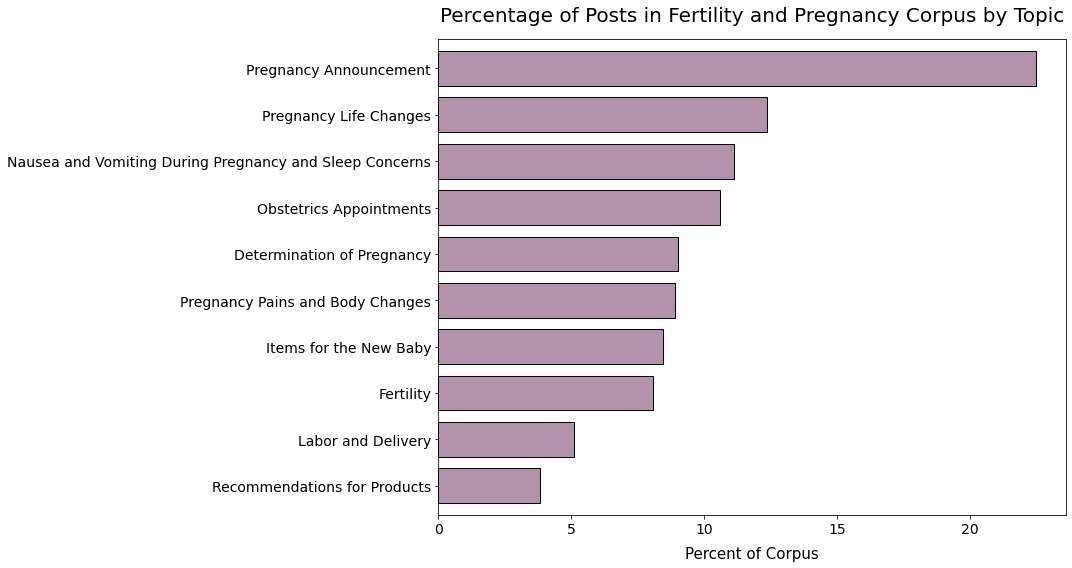

In [122]:
plot_topics_in_corpus(obsgyn_topic_df, 
                      'Dominant_Topic', 
                       dark_purple,
                       title = 'Percentage of Posts in Fertility and Pregnancy Corpus by Topic',
                       x_label = 'Percent of Corpus')

As shown above, the majority of the documents (posts) in the Fertility and Pregnancy corpus had the highest topic probabiility for the "Pregnancy Announcement" topic. In general, the majority of documents in this corpus do seem to be related to pregancy.

#### Evaluate the Topics by Assessing the Content of the Post Determined to Have the Highest Probability of Belonging to the Topic

In order to determine if the topics that I identified captured the meaning of the documents (posts), I filtered out the posts with the highest probability of belonging to a specified topic. I read each post and determined if the topic label seems to match the human-interpreted content. The results are presented in the data frame below.

In [123]:
obsgyn_posts_dict, obsgyn_dominance_dict = get_top_posts(obsgyn_topic_df)
top_obsgyn_posts_df = pd.DataFrame.from_dict({'Most Representative Post': obsgyn_posts_dict, 
                                              'Probability': obsgyn_dominance_dict,
                                              'Topic Match': {'Pregnancy Life Changes':'Yes',
                                                              'Pregnancy Announcement':'No',
                                                              'Labor and Delivery':'Yes',
                                                              'Nausea and Vomiting During Pregnancy and Sleep Concerns':'Yes',
                                                              'Determination of Pregnancy':'Yes',
                                                              'Recommendations for Products':'Yes',
                                                              'Fertility':'Yes',
                                                              'Items for the New Baby':'Yes',
                                                              'Obstetrics Appointments':'Yes',
                                                              'Pregnancy Pains and Body Changes':'Yes'}})

top_obsgyn_posts_df

,Most Representative Post,Probability,Topic Match
Recommendations for Products,**** Mamas - Favorite Maternity/Nursing Bras? ...,0.8380,Yes
Fertility,Should we go for IUI? Curious to hear from oth...,0.8960,Yes
Pregnancy Announcement,Struggling at weeks I'm a year old who was d...,0.9397,No
Determination of Pregnancy,Officially missed period and feeing nauseous f...,0.9147,Yes
Pregnancy Life Changes,Birth story: Baby River born / (wd) via emerge...,0.9444,Yes
Nausea and Vomiting During Pregnancy and Sleep Concerns,"Wife is weeks pregnant, she says I smell and ...",0.9102,Yes
Obstetrics Appointments,Low-Risk Is Not No Risk: My NIPT Experiences [...,0.9297,Yes
Pregnancy Pains and Body Changes,"Weeks and uncomfortable. Also, when the heck ...",0.9013,Yes
Items for the New Baby,The all encompassing super long post about eve...,0.9338,Yes
Labor and Delivery,Random Contractions Weeks Today I'm exactly ...,0.8903,Yes


In general, these topics seem to be a good fit for describing the content of the most representative post. The post that was most probable for "Pregnancy Announcement" did not seem to be a good fit, but I believe it was clustered in this topic due to the frequency of the word "tell" in the post. The most representative post for "Pregnancy Announcement" would likely be better clustered to "Pregnancy Life Changes".

## Product Recommendations

Overall, these analyses have shown that concerns related to women's health at various life stages can be identified using topic modeling techniques, such as Latent Dirichlet Allocation. 

Based on the identified clusters, I recommend that the following areas of women's health would benefit from having expert-provided advice and should therefore be considered for inclusion in the mobile application:

**For Non-Pregnant Users**
1. Menstrual Cycle Abnormalities
2. Feminine Hygiene Products
3. Birth Control Options
4. Symptoms of Infections
5. Common Gynecological Issues (Including pains)
6. Fertility Options

**For Pregnant Users**
1. Determination of pregnancy and early pregnancy symptoms
2. Coping with pregnancy life changes
3. Dealing with nausea and vomiting during pregnancy and sleep disruptions
4. Obstetrics Appointments (Including pain and body changes)
5. What to expect during labor and delivery


Understanding the serious nature of these areas of concern, for any pain, gynecological and obstetric issues, or mental health struggles, we will also emphasize that any content within the mobile application is not meant to replace discussions with a health care provider and will encourage users to seek help from their physician. 

## Conclusion

* This project provides proof-of-concept that, given the correct data, topic modeling with Latent Dirichlet Allocation can provide important insights into information that is normally gained through user surveys or focus groups and could become an important step in product development. 

* In comparison to focus groups or surveys, this project was able to analyze data from 19,753 unique users in the General Women's Health Data and 35,127 unique users in the Fertilty and Pregnancy data. Collecting the same quantity of data using surveys or focus groups would likely cost more financially and in terms of time.

* The biggest limitation to topic modeling is interpretation of clusters, but adequate research and background knowledge can facilitate this process.

* Next Steps:
    * Topic Modeling of concerns during Postpartum/Early Parenthood period
    * Identification of concerns for data collected pre- and post-COVID-19
    * Topic modeling within previously-identified topics

## References

[American Gut](https://msystems.asm.org/content/3/3/e00031-18)  
[Citizen Science](https://www.citizenscience.gov/about/#)  
[DNTS](https://www.dntshome.org)  
[First Major Results of “American Gut Project” Published](https://anesthesiology.duke.edu/?p=846744)  
[Latent Dirichlet Allocation](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)  
[Stemming and Lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)  

### Helpful Tutorials and Resources
[Coherence Scores - StackOverflow](https://stackoverflow.com/questions/54762690/coherence-score-0-4-is-good-or-bad)  
[Document Clustering with Python by Brandon Rose](http://brandonrose.org/clustering#Hierarchical-document-clustering)  
[KMeans Text Clustering by Learn Python](https://pythonprogramminglanguage.com/kmeans-text-clustering/)  
[Natural Language Processing in Action by Hobson Lane](https://www.amazon.com/gp/product/1617294632/ref=ppx_yo_dt_b_asin_title_o05_s00?ie=UTF8&psc=1)  
[NLP in Python Tutorial by A Dash of Data](https://github.com/adashofdata/nlp-in-python-tutorial)  
[Natural Language Processing with Python by Jose Portilla](https://www.udemy.com/course/nlp-natural-language-processing-with-python/)  
[Topic Modeling with Gensim by Machine Learning Plus](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)   